In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


In [3]:
import pickle
import scipy.optimize
import scipy.constants

In [4]:
# use uncertainties library (pip install uncertaintes)
from uncertainties import ufloat

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset

In [6]:
from tqdm import tqdm_notebook as tqdm

In [7]:
hbarc = (scipy.constants.hbar * scipy.constants.speed_of_light
         / scipy.constants.mega / scipy.constants.electron_volt / scipy.constants.femto)

ainv = 2.333e3
lat_unit = hbarc/ainv
momega = 1.71153e3/ainv
mn = 0.95469e3/ainv
mpi = 0.146e3/ainv
L = 96
bin_num = 20 # number of the jackknife sample
spin = 2

In [8]:
m_red = mn * momega/(mn + momega)

In [9]:
print(f'N = {mn*ainv:3.2f} [MeV], Omega = {momega*ainv:3.2f} [MeV]')
print(f'redueced mass = {m_red*ainv:3.2f} [MeV]')

N = 954.69 [MeV], Omega = 1711.53 [MeV]
redueced mass = 612.85 [MeV]


In [10]:
V_fit = lambda p, x: p[0] * np.exp(-p[1]*x**2) + p[2] *  (
                1 - np.exp(-p[3]*x**2)) * (np.exp(-mpi*x)/(x+1.0e-5))**2

In [11]:
with open('pkls/FF_yukawa2_fit_result.pkl', 'rb') as fin:
    FF_yukawa2_prm_av, FF_yukawa2_prm_jk = pickle.load(fin)

check potential

Text(0.5,1.02,'$N\\Omega$($^{5}$S$_{2}$), $t/a = 12$')

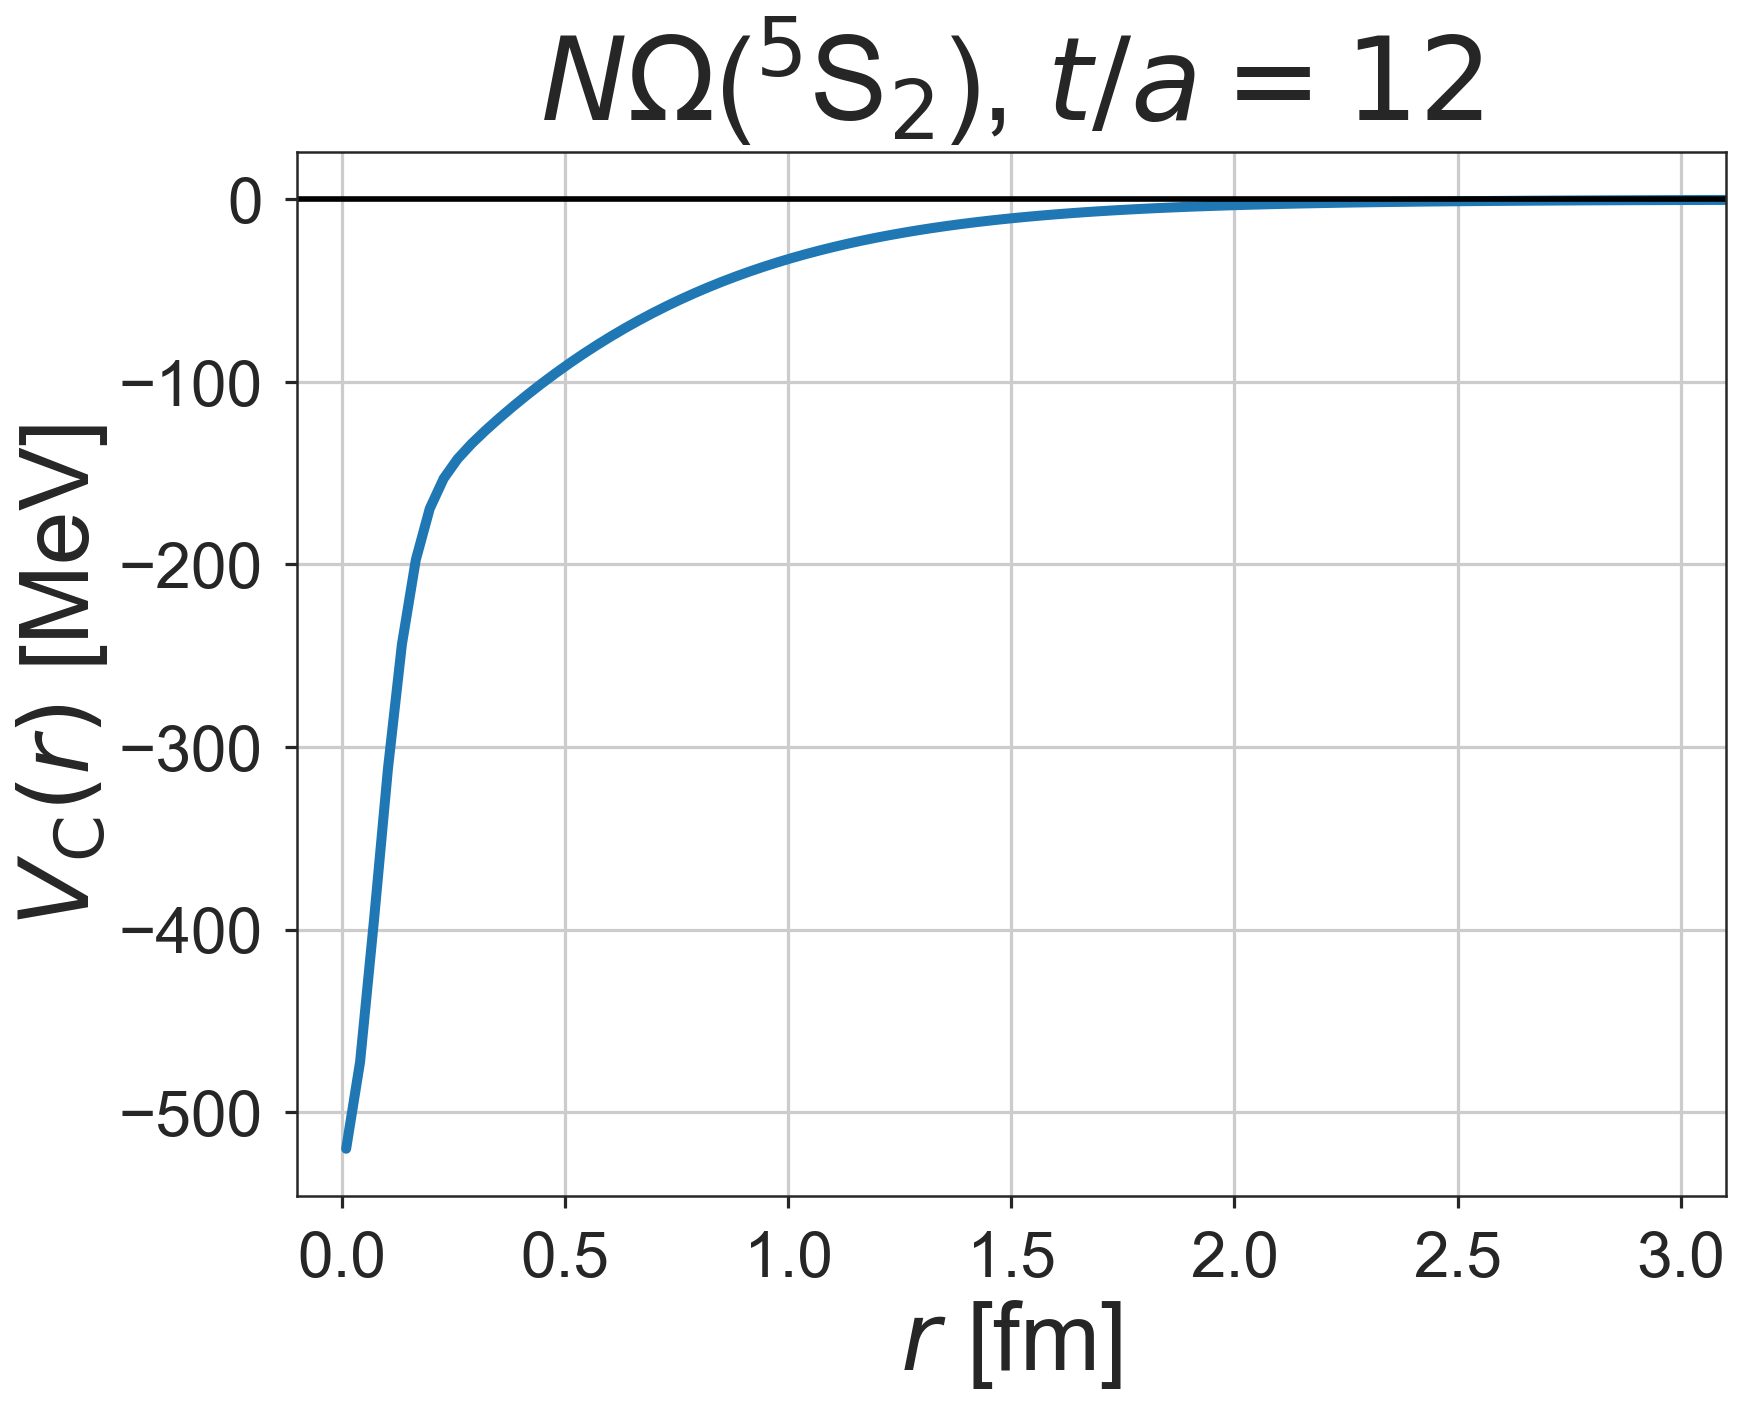

In [12]:
it = 12
xls = np.linspace(0.01, 3.10, 100)/lat_unit
fig, ax = plt.subplots()
ax.plot(xls*lat_unit, V_fit(FF_yukawa2_prm_av[it], xls)*ainv, lw=5)
ax.axhline(0, color='black')
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$V_\mathrm{C}(r)$ [MeV]', size=48)
ax.set_xlim(-0.10, 3.10)
ax.set_title(rf'$N\Omega$($^{{{spin*2+1:d}}}$S$_{{{spin:d}}}$), $t/a = {it:d}$', size=58, y=1.02)



Schroedinger Eq.

In [13]:
class Schroedinger_Eq(object):
    """Calculate the scattering phase shifts by solving Schroedinger Eq.
    
    All parameters are in lattice unit.
    """
    def __init__(self, pot, red_mass, r_min = 1.0e-5, r_max = 10/lat_unit, r_diff = 1.0e-3):
        self.pot = pot
        self.rs = np.arange(r_min, r_max, r_diff)
        self.red_mass = red_mass
        
    def sch_eq(self, uv, r, k2):
        """
        u = psi(r)/r with u(0) = 0
        solve
        u'' = - 2 mu (E - V(r)) u
        -->
        u' = v
        v' = - (k^2 - 2 mu V(r)) u
        """
        du = uv[1]
        dv = - (k2 - 2 * self.red_mass * self.pot(r)) * uv[0]
        return np.array([du, dv])
        
    def conv_delta(self, r, u, u_prime, k):
        return np.mod(np.arctan(k*u/u_prime) - k*r, np.pi)
    
    def plot_asymptotic_behavior(self, k2, u_prime_ini=1.0e-3):
        """
        This method checks convergence of the phase shift.
        """
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs,
                            args=(k2,))
        fig, ax = plt.subplots()
        ax.plot(self.rs, self.conv_delta(self.rs, trj[:,0], trj[:,1], np.sqrt(k2)),
               label=r'$k^2 = {}$'.format(k2))
        ax.set_xlabel(r'$r$', size=48)
        ax.set_ylabel(r'$\delta$ [rad.]', size=48)
        leg = ax.legend(frameon=True)
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_linewidth(2.0)
        return ax
        
    def calc_phase_shift(self, k2, u_prime_ini=1.0e-3):
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs,
                            args=(k2,))

        return self.conv_delta(self.rs[-1], trj[-1,0], trj[-1,1], np.sqrt(k2))       

Considering the Schroedinger Eq.
\begin{equation}
[H_0 +  V]\psi = E \psi
\end{equation}
and $\psi(r) = u(r)/r$ with $u(0) = 0$.

We obtain
\begin{equation}
\frac{d^2}{dr^2}u = - 2\mu[E - V]u
\end{equation}

The asymptotic wave function for the binding system,
\begin{equation}
\psi_\mathrm{asymp} \propto e^{-\kappa r}/r
\end{equation}
with $\kappa = \sqrt{-2\mu E}$.

The binding energy is estimated by
\begin{equation}
\frac{u'}{u} = - \kappa \rightarrow u' + \kappa u = 0
\end{equation}
at $r = r_0$

\begin{equation}
\langle r^2 \rangle = \frac{\int r^2 |\psi|^2 d^3x}{\int |\psi|^2 d^3x} = \frac{\int r^2 u^2 dr}{\int u^2 dr}
\end{equation}


In [14]:
class Search_Bound_State(Schroedinger_Eq):
    """
    Seach Bound State for given Schroedinger Eq.
    
    All parameters are given in lattice unit
    """
    def check_BE_window(self, Emin, Emax, u_prime_ini=1.0e-3, ax=None):
        """
        Check energy window for the binding energy
        
        Emin (Emax): lower (upper) bound
        """
        if not ax:
            fig, ax = plt.subplots()
        Es = np.linspace(Emin, Emax, 10)
        Wr = []
        for E in Es:
            # E = k^2/(2m_red)
            trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini),
                                        self.rs, args=(2.0*self.red_mass*E, ))
            Wr.append(trj[-1,1] + np.sqrt(-2.0*self.red_mass*E)*trj[-1,0])

        ax.plot(Es*ainv, Wr, '-o', color='red')
        ax.axhline(0, color='black')
        ax.set_xlabel(r'$E$ [MeV]', size=48)
        ax.set_ylabel(r'$u + \sqrt{-2m_\mu E} u$', size=48)
    
    def calc_binding_energy(self, Emin, Emax, u_prime_ini=1.0e-3):
        """
        calculate binding energy
        
        Emin (Emax): lower (upper) bound of initial energy
        """
        def cond(E):
            trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini),
                                        self.rs, args=(2.0*self.red_mass*E, ))
            return trj[-1,1] + np.sqrt(-2.0*self.red_mass*E)*trj[-1,0]
        return scipy.optimize.bisect(cond, Emin, Emax)
    
    def calc_rms_distance(self, Emin, Emax, u_prime_ini=1.0e-3):
        """
        calculate root mean square distance
        
        Emin (Emax): lower (upper) bound of initial energy
        """
        E = self.calc_binding_energy(Emin, Emax, u_prime_ini=u_prime_ini)
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini),
                                    self.rs, args=(2.0*self.red_mass*E, ))
        
        return self.root_mean_square_distance(self.rs, trj[:,0], E)
        
    def root_mean_square_distance(self, rs, u, E):
        kappa = np.sqrt(-2.0*self.red_mass*E)
        dr = rs[1] - rs[0]
        r0 = rs[-1]
        A = u[-1] * np.exp(kappa*r0)
        nume = np.sum(rs**2*u**2)*dr + A**2/(4*kappa**3) * (
            1 + 2*r0*kappa+2*r0**2*kappa**2)*np.exp(-2*kappa*r0)
        denom = np.sum(u**2)*dr + A**2*np.exp(-2*kappa*r0)/(2*kappa)
        return np.sqrt(nume/denom)

example of binding energy and root mean square distance

2.00 fm -> -1.26 MeV, 4.05 fm
5.00 fm -> -1.54 MeV, 3.77 fm
10.00 fm -> -1.54 MeV, 3.77 fm
15.00 fm -> -1.54 MeV, 3.77 fm


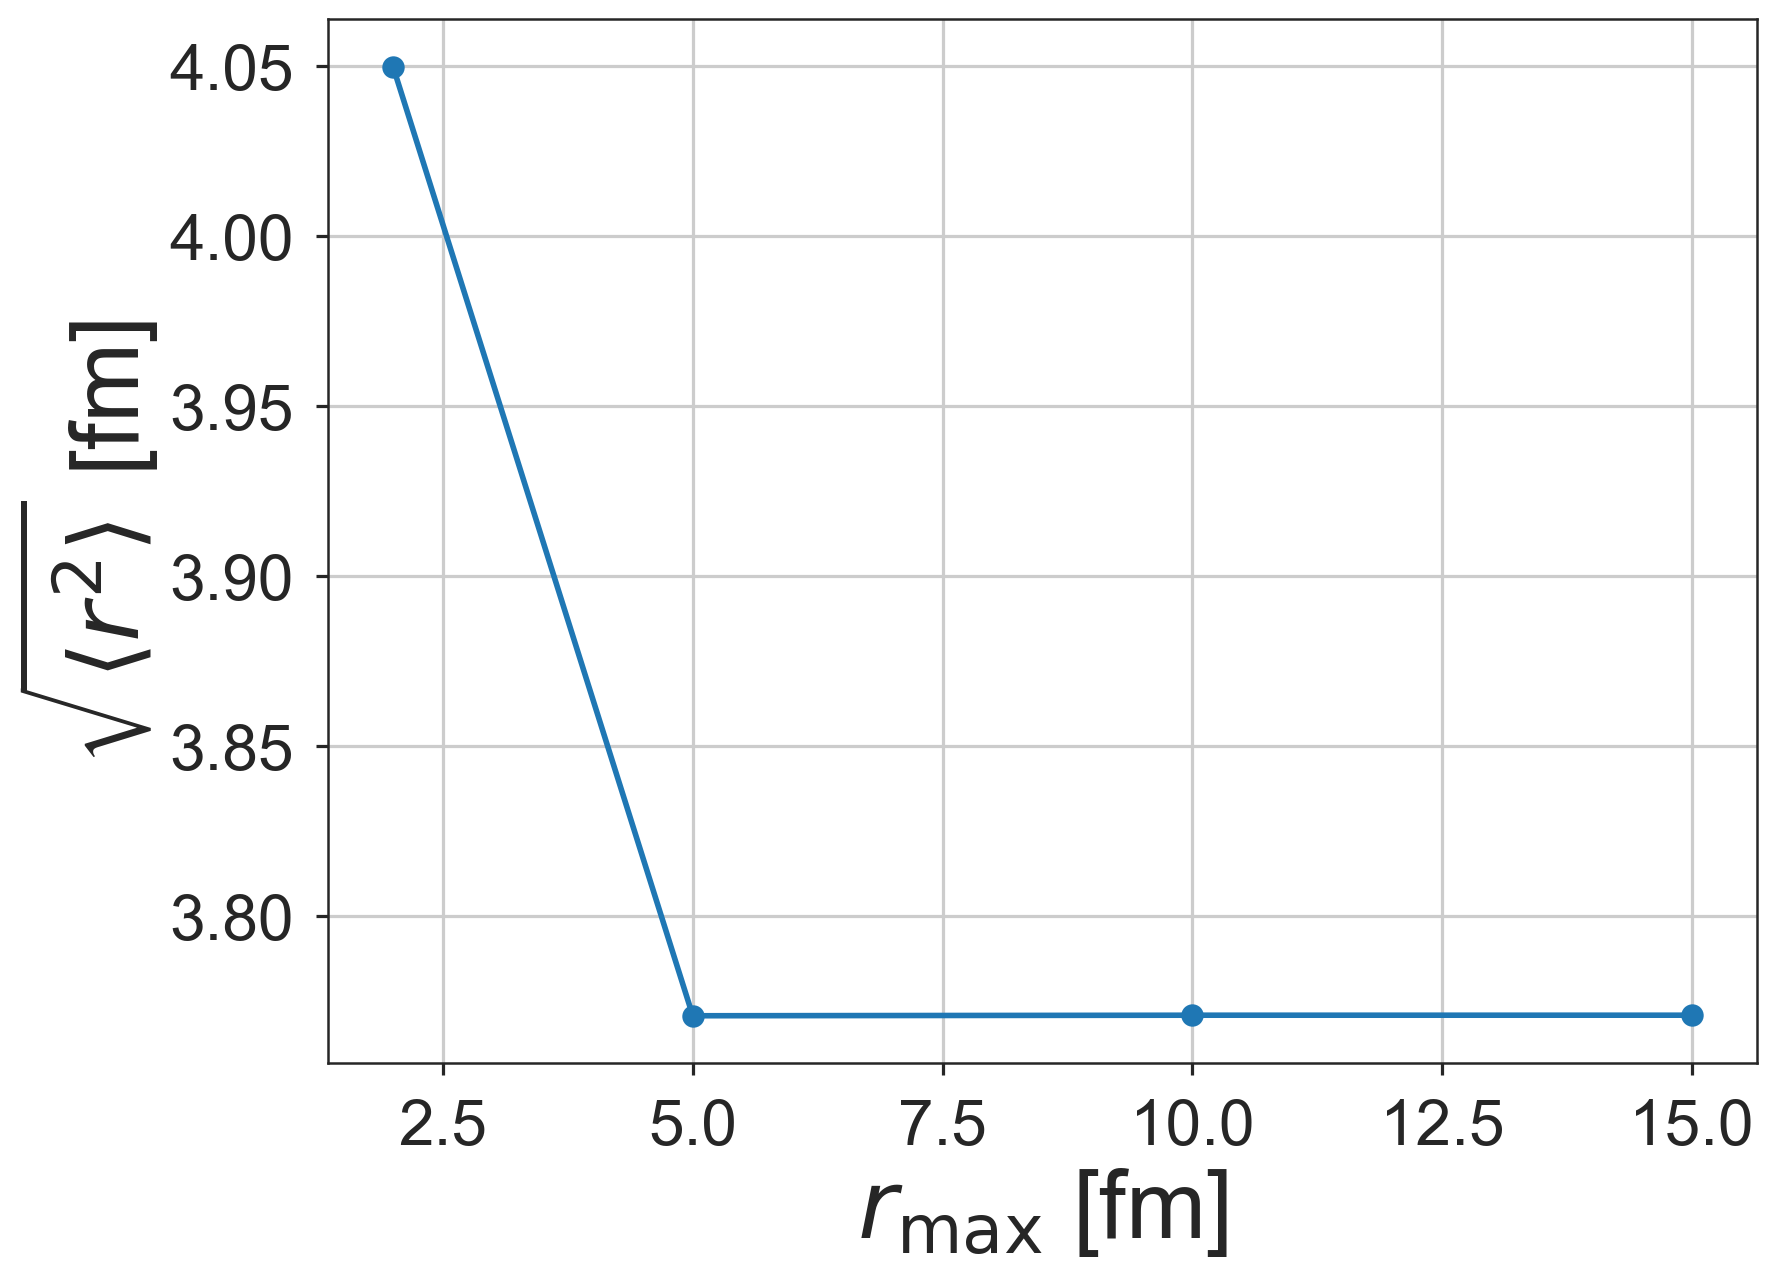

In [15]:
def check_rms_convergence(pot, Emin, Emax, rmax_list):
    rms_list = []
    for r_max in rmax_list:
        sbs = Search_Bound_State(pot, m_red, r_max = r_max)
        E = sbs.calc_binding_energy(Emin, Emax)
        rms = sbs.calc_rms_distance(Emin, Emax)
        print(f'{r_max*lat_unit:3.2f} fm -> {E*ainv:3.2f} MeV, {rms*lat_unit:3.2f} fm')
        rms_list.append(rms)
        
    fig, ax = plt.subplots()
    ax.plot(np.array(rmax_list)*lat_unit, np.array(rms_list)*lat_unit, '-o')
    ax.set_xlabel(r'$r_\mathrm{max}$ [fm]', size=48)
    ax.set_ylabel(r'$\sqrt{\langle r^2 \rangle}$ [fm]', size=48)

it = 12
pot = lambda x: V_fit(FF_yukawa2_prm_av[it], x)
check_rms_convergence(pot, -2.5/ainv, -0.5/ainv, np.array([2, 5, 10, 15])/lat_unit)


BE = 1.54 MeV
rms = 3.77 fm


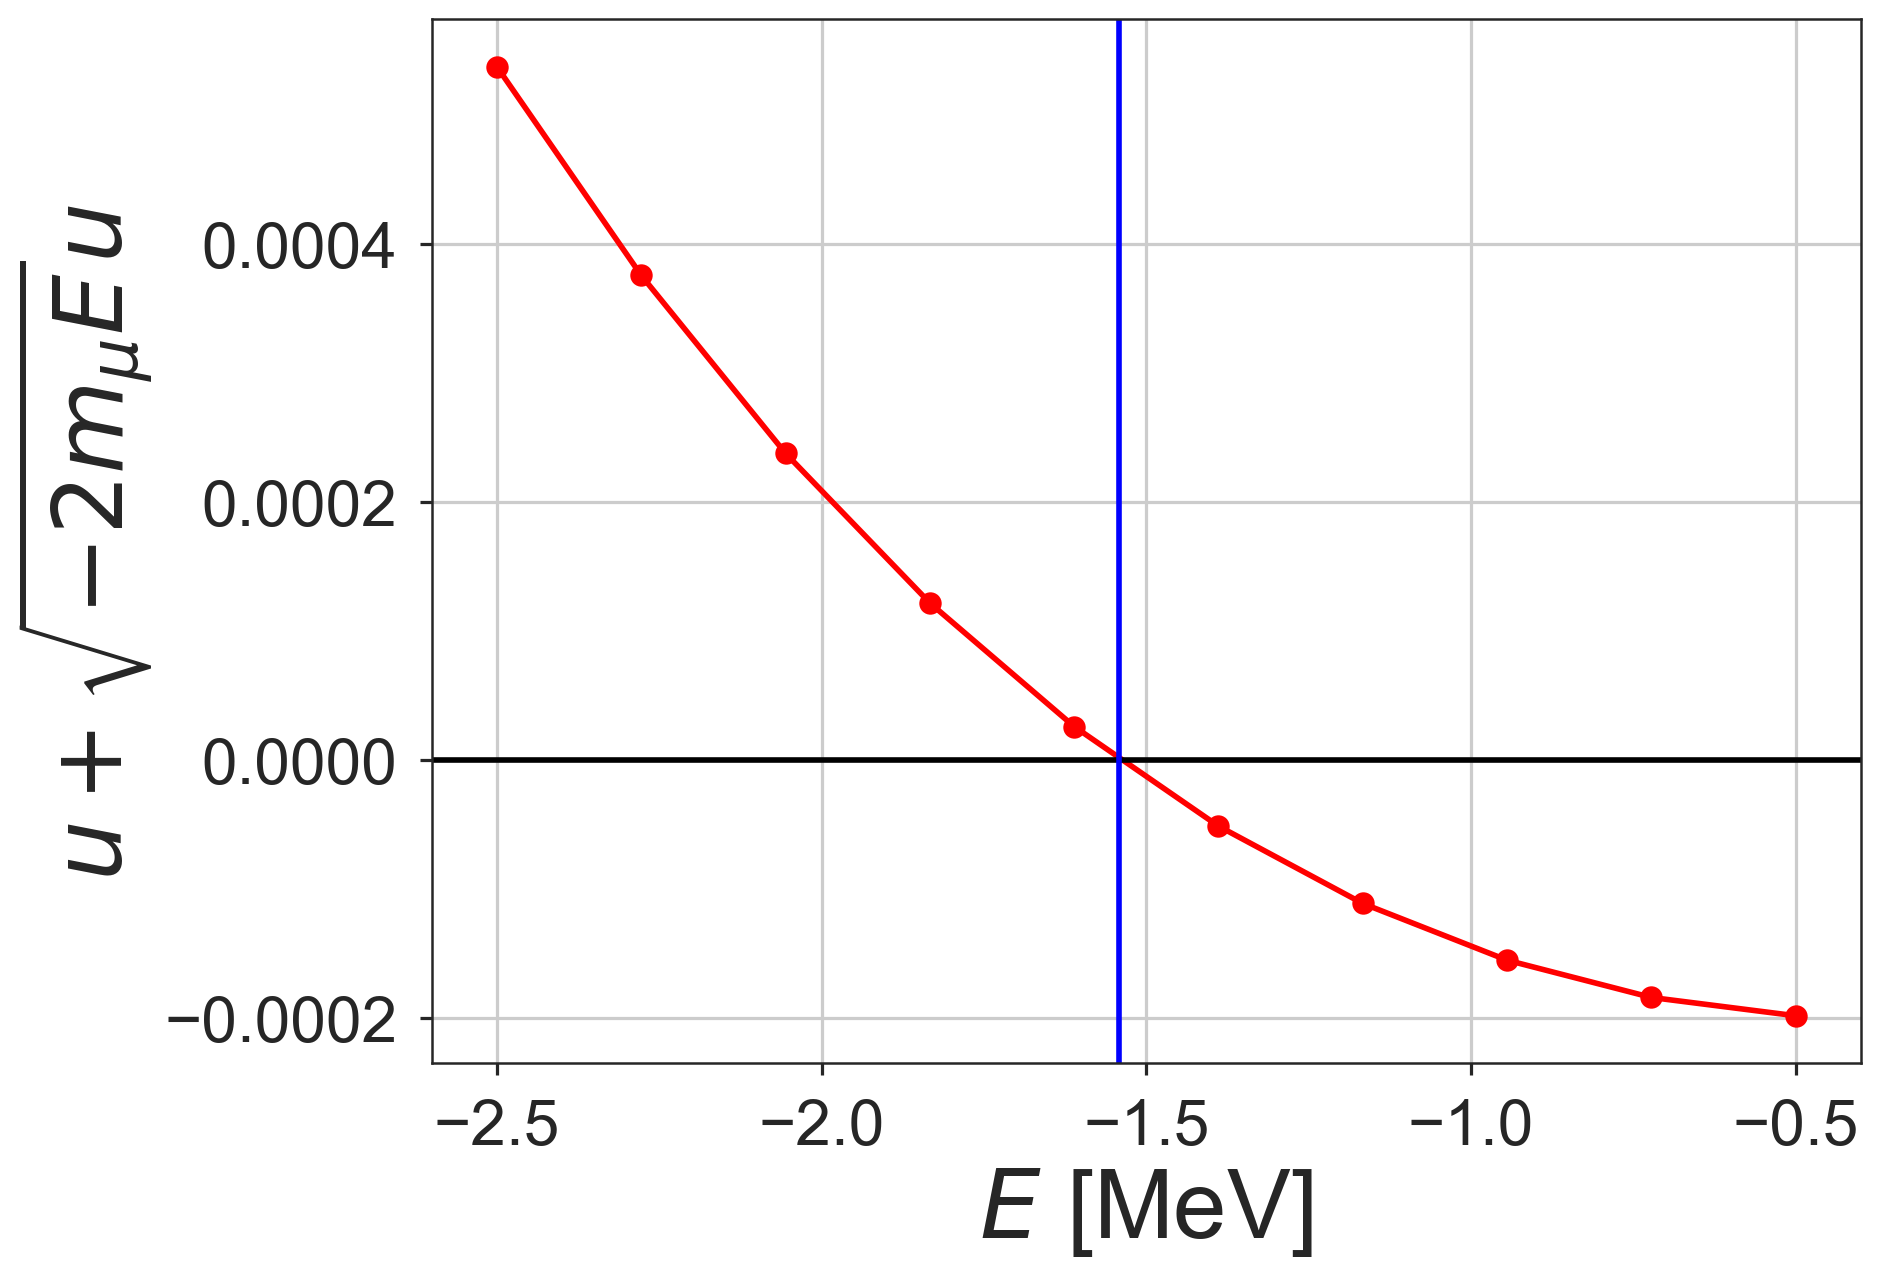

In [16]:
it = 12
pot = lambda x: V_fit(FF_yukawa2_prm_av[it], x)
sbs = Search_Bound_State(pot, m_red)
fig, ax = plt.subplots()
sbs.check_BE_window(-2.5/ainv, -0.5/ainv, ax=ax)
E = sbs.calc_binding_energy(-2.0/ainv, -0.5/ainv)*ainv
print('BE = {:3.2f} MeV'.format(-E))
ax.axvline(E, color='blue')
rms  = sbs.calc_rms_distance(-2.0/ainv, -0.5/ainv)*lat_unit
print('rms = {:3.2f} fm'.format(rms))

another cross check $\Omega\Omega$($^1$S$_0$)

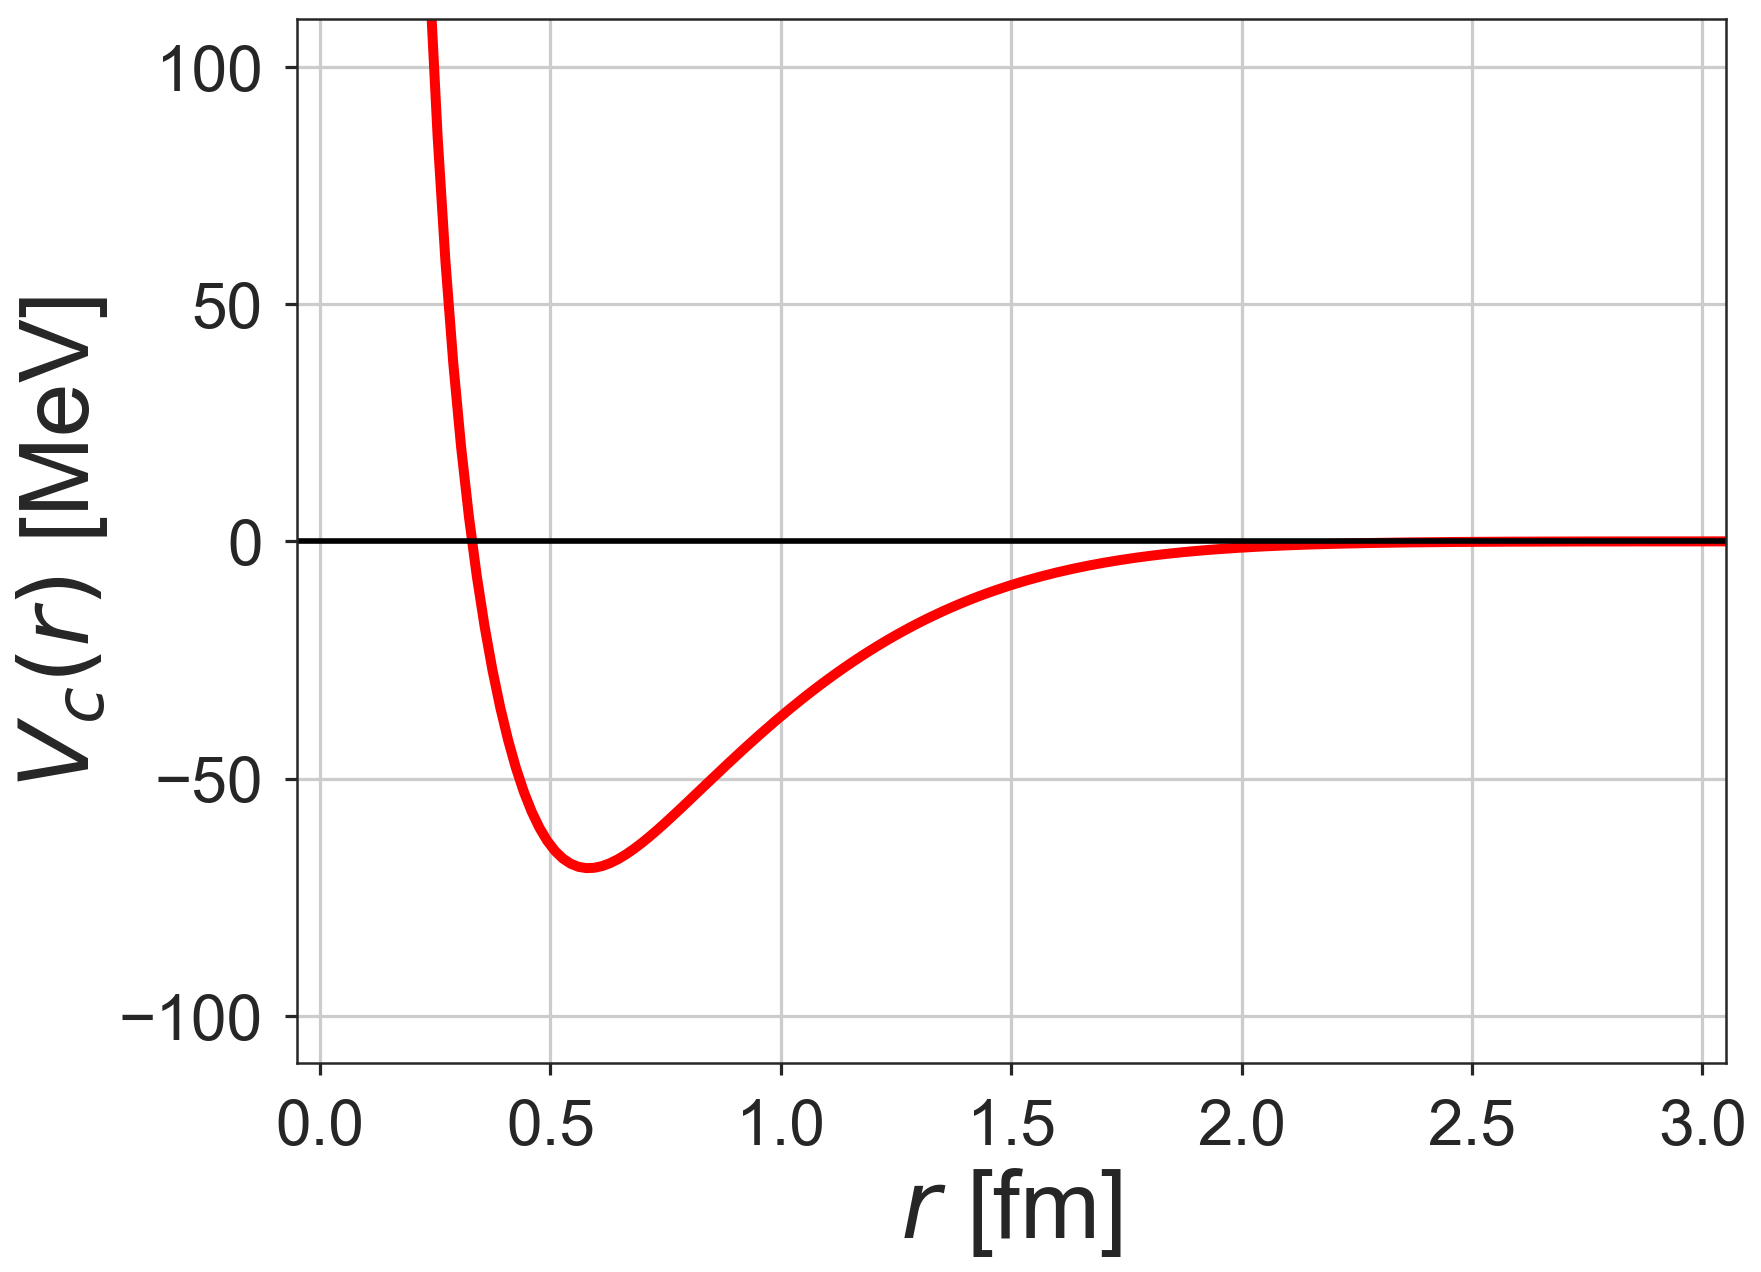

In [17]:
cs = np.array([914, 305, -112])/ainv
ds = np.array([0.143,  0.305,  0.949])/lat_unit
pot_diomega = lambda x : cs[0]*np.exp(-(x/ds[0])**2) +  cs[1]*np.exp(-(x/ds[1])**2) + cs[2]*np.exp(-(x/ds[2])**2)
xls = np.linspace(0, 40, 200)
fig, ax = plt.subplots()
ax.plot(xls*lat_unit, pot_diomega(xls)*ainv, color='red', lw=5)
ax.axhline(0, color='black')
ax.set_ylim(-110, 110)
ax.set_xlim(-0.05, 3.05)
ax.set_xlabel(r'$r$ [fm]',  size=48)
ax.set_ylabel(r'$V_c(r)$ [MeV]', size=48);

BE = 1.63 MeV
RMS = 3.2 fm


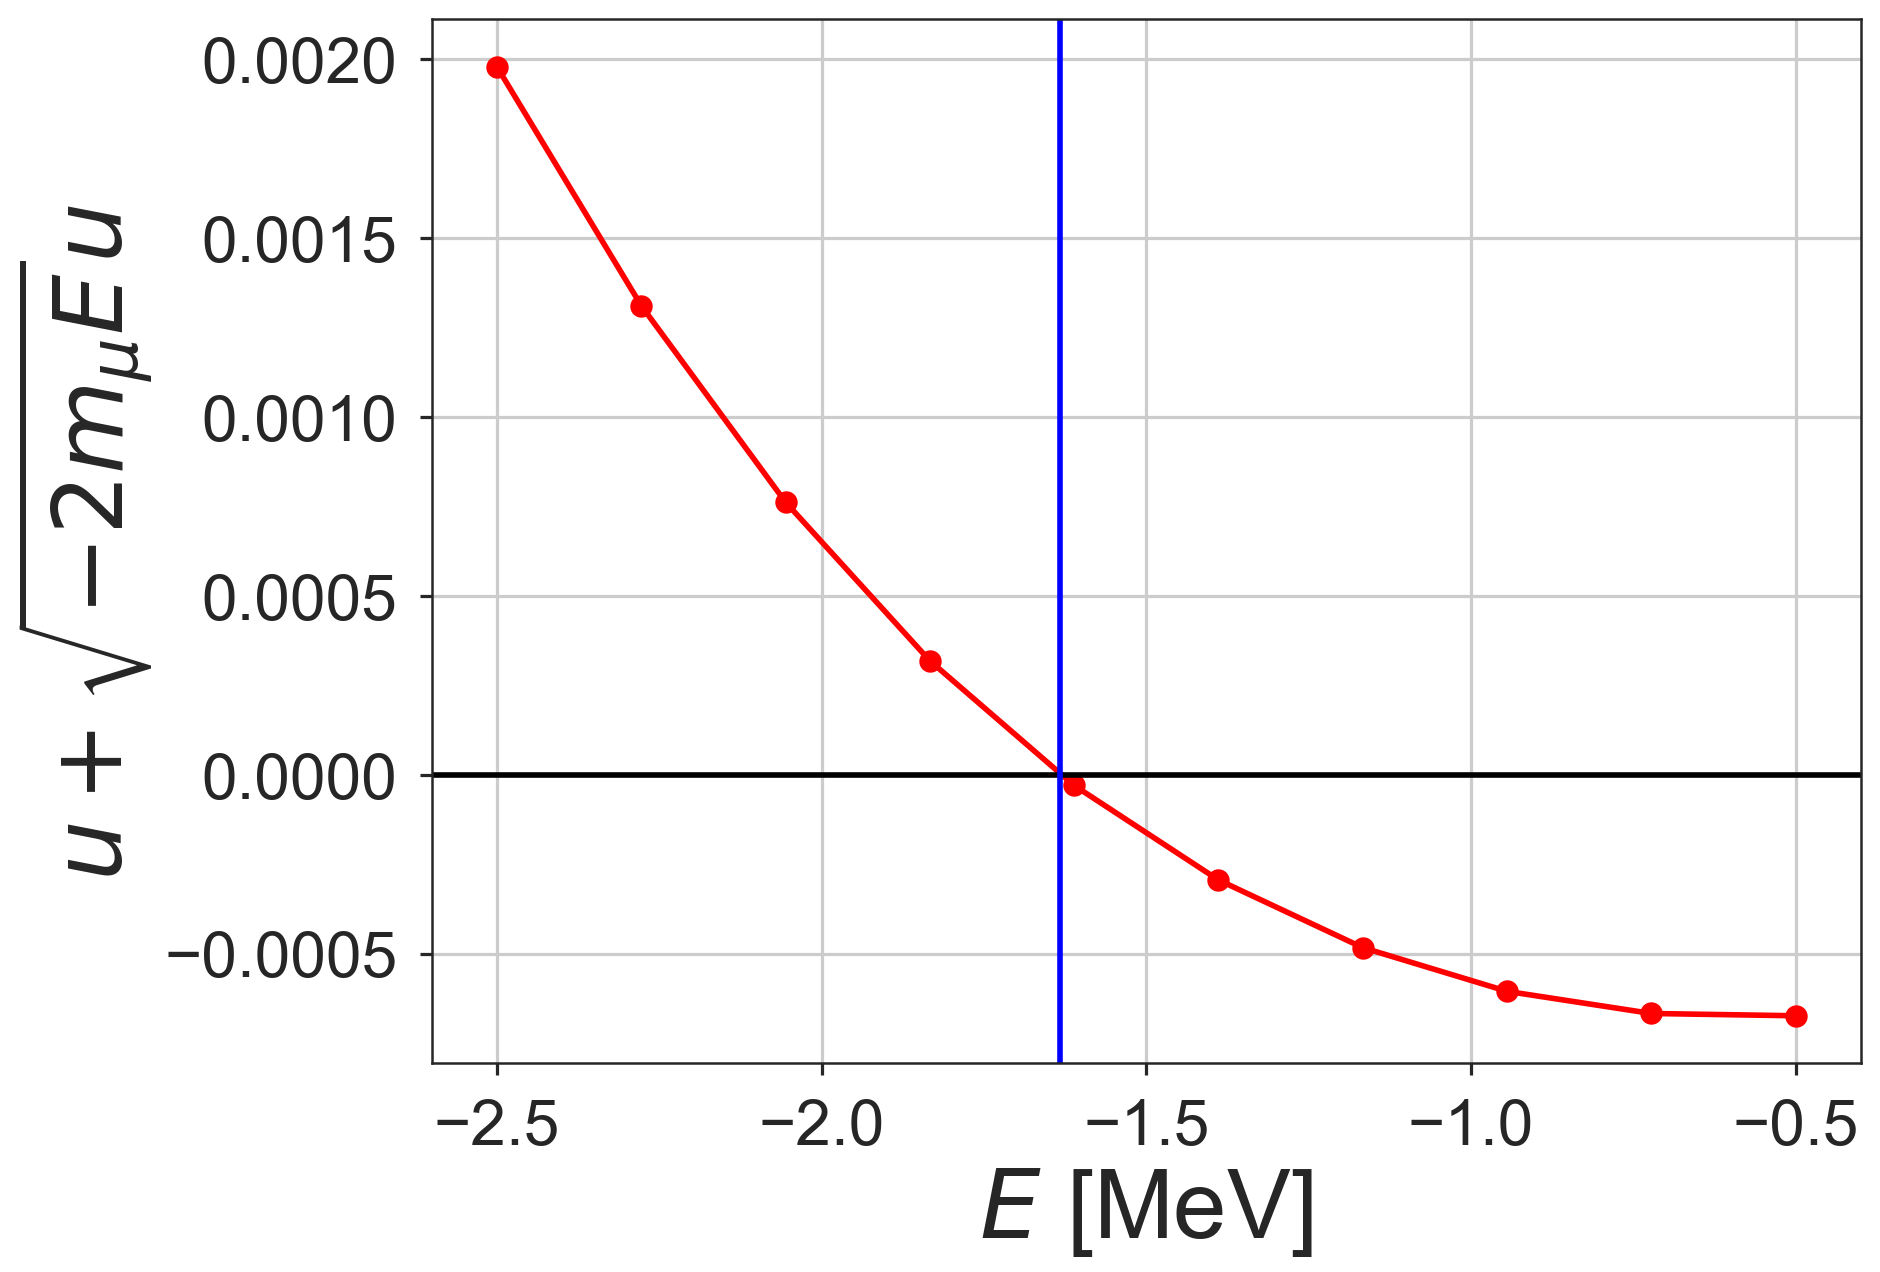

In [18]:
sbs = Search_Bound_State(pot_diomega, 0.5*momega)
fig, ax = plt.subplots()
sbs.check_BE_window(-2.5/ainv, -0.5/ainv, ax=ax)
E = sbs.calc_binding_energy(-2.0/ainv, -0.5/ainv)*ainv
print('BE = {:3.2f} MeV'.format(-E))
ax.axvline(E, color='blue')
print('RMS = {:3.1f} fm'.format(sbs.calc_rms_distance(-2.0/ainv, -0.5/ainv)*lat_unit))

# calculate binding energy & root mean squre distance

In [19]:
BE_jk = {}
RMS_jk = {}

In [20]:
it = 11
tmp_E = []
tmp_rms = []
print(f't = {it}')
for ibin in range(bin_num):
    pot = lambda x: V_fit(FF_yukawa2_prm_jk[it][ibin,:], x)
    sbs = Search_Bound_State(pot, m_red)
    E = sbs.calc_binding_energy(-3.0/ainv, -0.5/ainv)
    print(f'{ibin:02d} {E*ainv:3.2f} MeV', end=',')
    tmp_E.append(E)
    
    rms = sbs.calc_rms_distance(-3.0/ainv, -0.5/ainv)
    print(f' {rms*lat_unit:3.2f} fm')
    tmp_rms.append(rms)

BE_jk[it] = np.array(tmp_E)
RMS_jk[it] = np.array(tmp_rms)

t = 11
00 -1.60 MeV, 3.73 fm
01 -1.52 MeV, 3.80 fm
02 -1.51 MeV, 3.82 fm
03 -1.48 MeV, 3.84 fm
04 -1.41 MeV, 3.92 fm
05 -1.57 MeV, 3.75 fm
06 -1.36 MeV, 3.98 fm
07 -1.51 MeV, 3.81 fm
08 -1.49 MeV, 3.83 fm
09 -1.49 MeV, 3.83 fm
10 -1.59 MeV, 3.74 fm
11 -1.43 MeV, 3.90 fm
12 -1.41 MeV, 3.92 fm
13 -1.44 MeV, 3.89 fm
14 -1.46 MeV, 3.87 fm
15 -1.56 MeV, 3.77 fm
16 -1.63 MeV, 3.70 fm
17 -1.51 MeV, 3.81 fm
18 -1.48 MeV, 3.84 fm
19 -1.50 MeV, 3.83 fm


In [21]:
it = 12
tmp_E = []
tmp_rms = []
print(f't = {it}')
for ibin in range(bin_num):
    pot = lambda x: V_fit(FF_yukawa2_prm_jk[it][ibin,:], x)
    sbs = Search_Bound_State(pot, m_red)
    E = sbs.calc_binding_energy(-3.0/ainv, -0.5/ainv)
    print(f'{ibin:02d} {E*ainv:3.2f} MeV', end=',')
    tmp_E.append(E)
    
    rms = sbs.calc_rms_distance(-3.0/ainv, -0.5/ainv)
    print(f' {rms*lat_unit:3.2f} fm')
    tmp_rms.append(rms)

BE_jk[it] = np.array(tmp_E)
RMS_jk[it] = np.array(tmp_rms)

t = 12
00 -1.69 MeV, 3.63 fm
01 -1.55 MeV, 3.76 fm
02 -1.65 MeV, 3.66 fm
03 -1.58 MeV, 3.73 fm
04 -1.41 MeV, 3.91 fm
05 -1.53 MeV, 3.79 fm
06 -1.45 MeV, 3.87 fm
07 -1.59 MeV, 3.72 fm
08 -1.60 MeV, 3.72 fm
09 -1.55 MeV, 3.75 fm
10 -1.58 MeV, 3.74 fm
11 -1.59 MeV, 3.72 fm
12 -1.52 MeV, 3.80 fm
13 -1.44 MeV, 3.87 fm
14 -1.54 MeV, 3.77 fm
15 -1.58 MeV, 3.73 fm
16 -1.57 MeV, 3.74 fm
17 -1.48 MeV, 3.83 fm
18 -1.49 MeV, 3.83 fm
19 -1.46 MeV, 3.85 fm


In [22]:
it = 13
tmp_E = []
tmp_rms = []
print(f't = {it}')
for ibin in range(bin_num):
    pot = lambda x: V_fit(FF_yukawa2_prm_jk[it][ibin,:], x)
    sbs = Search_Bound_State(pot, m_red)
    E = sbs.calc_binding_energy(-3.0/ainv, -0.5/ainv)
    print(f'{ibin:02d} {E*ainv:3.2f} MeV', end=',')
    tmp_E.append(E)
    
    rms = sbs.calc_rms_distance(-3.0/ainv, -0.5/ainv)
    print(f' {rms*lat_unit:3.2f} fm')
    tmp_rms.append(rms)

BE_jk[it] = np.array(tmp_E)
RMS_jk[it] = np.array(tmp_rms)

t = 13
00 -1.52 MeV, 3.79 fm
01 -1.48 MeV, 3.83 fm
02 -1.69 MeV, 3.63 fm
03 -1.37 MeV, 3.95 fm
04 -1.32 MeV, 4.02 fm
05 -1.59 MeV, 3.72 fm
06 -1.53 MeV, 3.78 fm
07 -1.38 MeV, 3.94 fm
08 -1.49 MeV, 3.82 fm
09 -1.44 MeV, 3.87 fm
10 -1.29 MeV, 4.06 fm
11 -1.79 MeV, 3.54 fm
12 -1.36 MeV, 3.97 fm
13 -1.39 MeV, 3.93 fm
14 -1.48 MeV, 3.83 fm
15 -1.54 MeV, 3.77 fm
16 -1.39 MeV, 3.94 fm
17 -1.20 MeV, 4.18 fm
18 -1.30 MeV, 4.04 fm
19 -1.27 MeV, 4.08 fm


In [23]:
it = 14
tmp_E = []
tmp_rms = []
print(f't = {it}')
for ibin in range(bin_num):
    pot = lambda x: V_fit(FF_yukawa2_prm_jk[it][ibin,:], x)
    sbs = Search_Bound_State(pot, m_red)
    E = sbs.calc_binding_energy(-3.0/ainv, -0.5/ainv)
    print(f'{ibin:02d} {E*ainv:3.2f} MeV', end=',')
    tmp_E.append(E)
    
    rms = sbs.calc_rms_distance(-3.0/ainv, -0.5/ainv)
    print(f' {rms*lat_unit:3.2f} fm')
    tmp_rms.append(rms)

BE_jk[it] = np.array(tmp_E)
RMS_jk[it] = np.array(tmp_rms)

t = 14
00 -1.70 MeV, 3.64 fm
01 -1.47 MeV, 3.86 fm
02 -1.85 MeV, 3.51 fm
03 -1.34 MeV, 4.00 fm
04 -1.56 MeV, 3.76 fm
05 -1.83 MeV, 3.54 fm
06 -1.74 MeV, 3.60 fm
07 -1.32 MeV, 4.02 fm
08 -1.65 MeV, 3.69 fm
09 -1.61 MeV, 3.71 fm
10 -1.18 MeV, 4.23 fm
11 -2.26 MeV, 3.23 fm
12 -1.63 MeV, 3.70 fm
13 -1.45 MeV, 3.88 fm
14 -1.69 MeV, 3.65 fm
15 -1.72 MeV, 3.61 fm
16 -1.38 MeV, 3.95 fm
17 -1.27 MeV, 4.09 fm
18 -1.37 MeV, 3.97 fm
19 -1.61 MeV, 3.71 fm


11 3.829 0.304 1.497 0.290
12 3.772 0.309 1.542 0.305
13 3.884 0.671 1.441 0.614
14 3.766 0.993 1.582 1.053


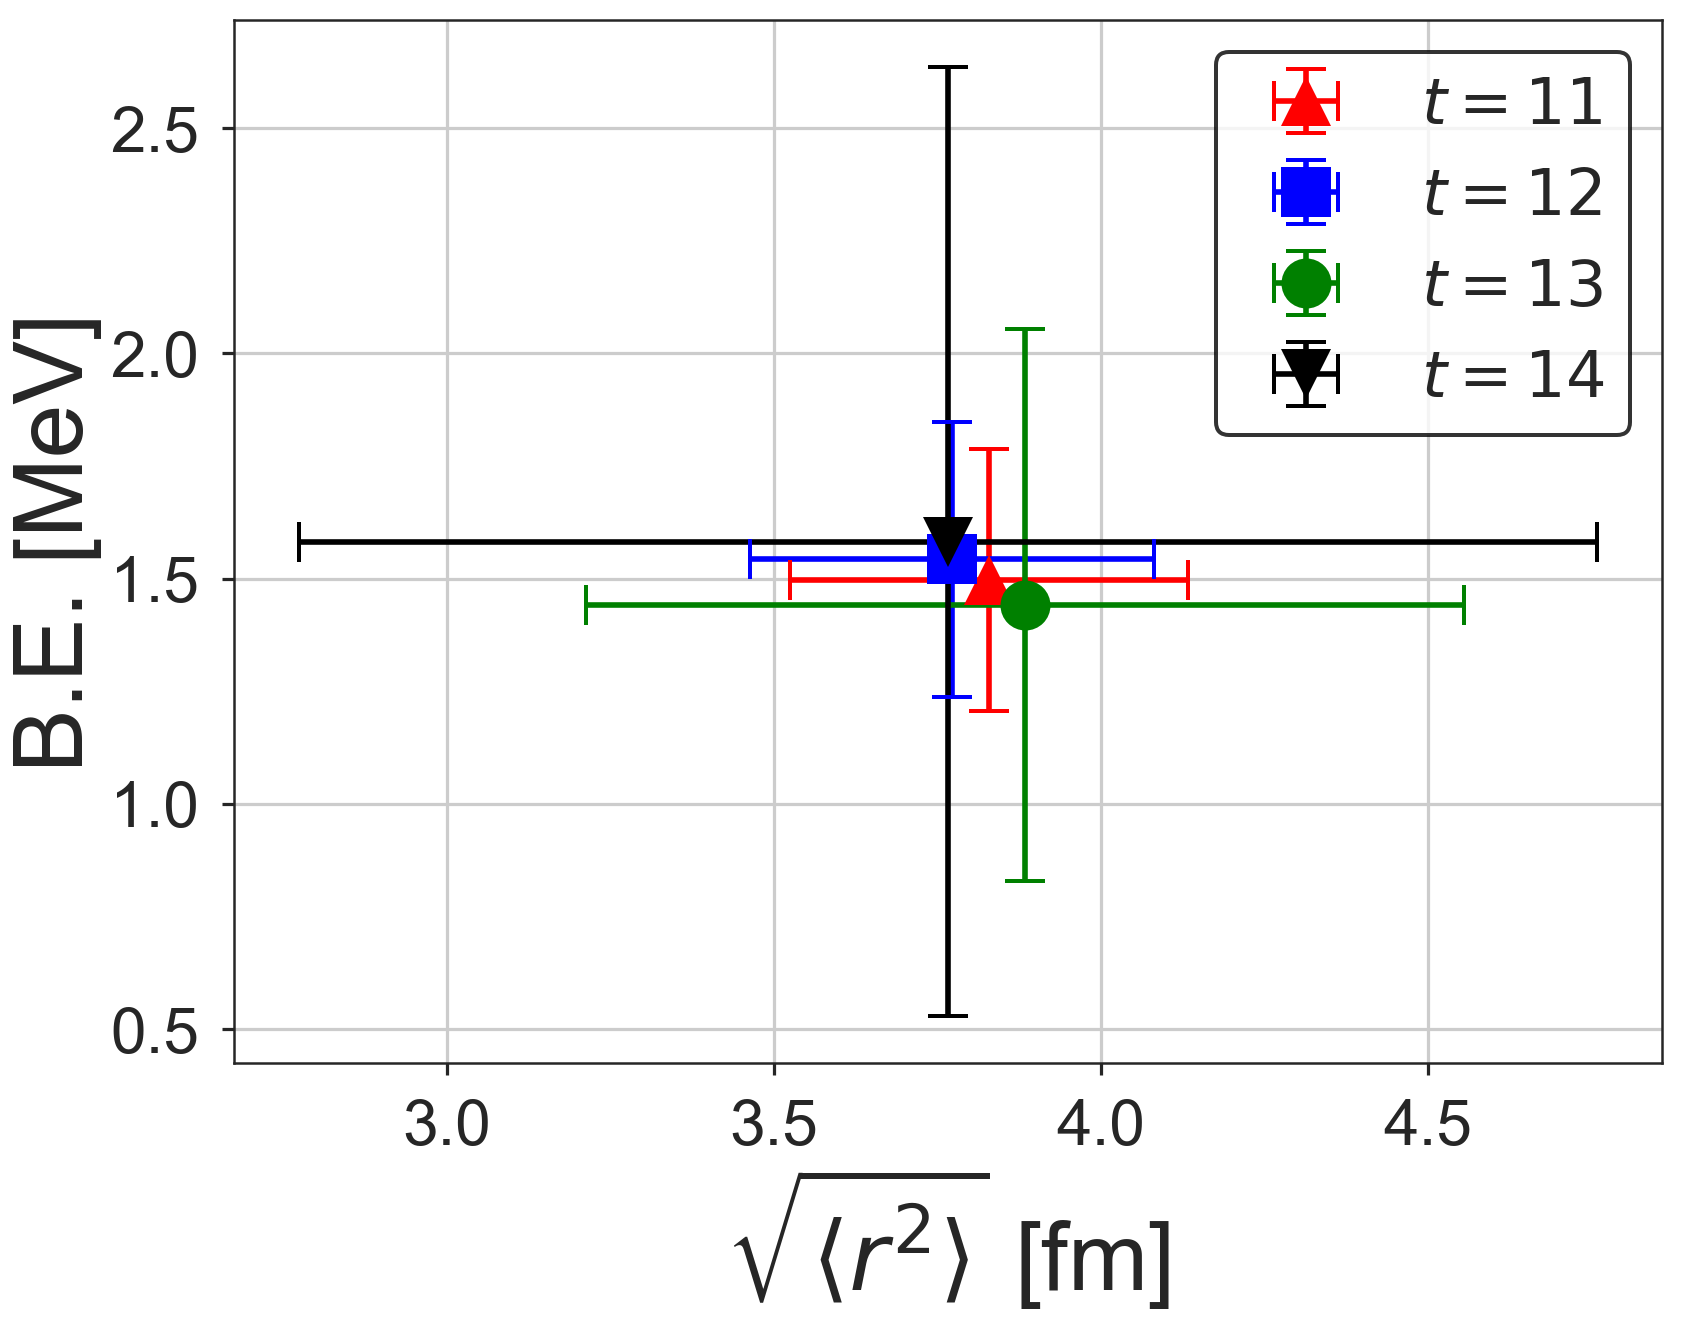

In [24]:
fig, ax = plt.subplots()
for it, fmt, col in zip([11, 12, 13, 14], ['^', 's', 'o', 'v'],
                        ['red', 'blue', 'green', 'black']):
    _xs = RMS_jk[it]*lat_unit
    _ys = -BE_jk[it]*ainv
    ax.errorbar(_xs.mean(), _ys.mean(), _ys.std()*np.sqrt(bin_num-1),
               xerr = _xs.std()*np.sqrt(bin_num-1),
               fmt=fmt,color=col,ms=25, capsize=10, capthick=2.0,
               label=r'$t = {}$'.format(it))
    print('{} {:4.3f} {:4.3f} {:4.3f} {:4.3f}'.format(it, _xs.mean(), _xs.std()*np.sqrt(bin_num-1), _ys.mean(), _ys.std()*np.sqrt(bin_num-1)))
    
ax.set_xlabel(r'$\sqrt{\langle r^2 \rangle}$ [fm]', size=48)
ax.set_ylabel(r'B.E. [MeV]', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

In [25]:
mkdir -p ../figs/binding_energy

3.77(0.31)(+0.11)(-0.01)
1.54(0.30)(+0.04)(-0.10)


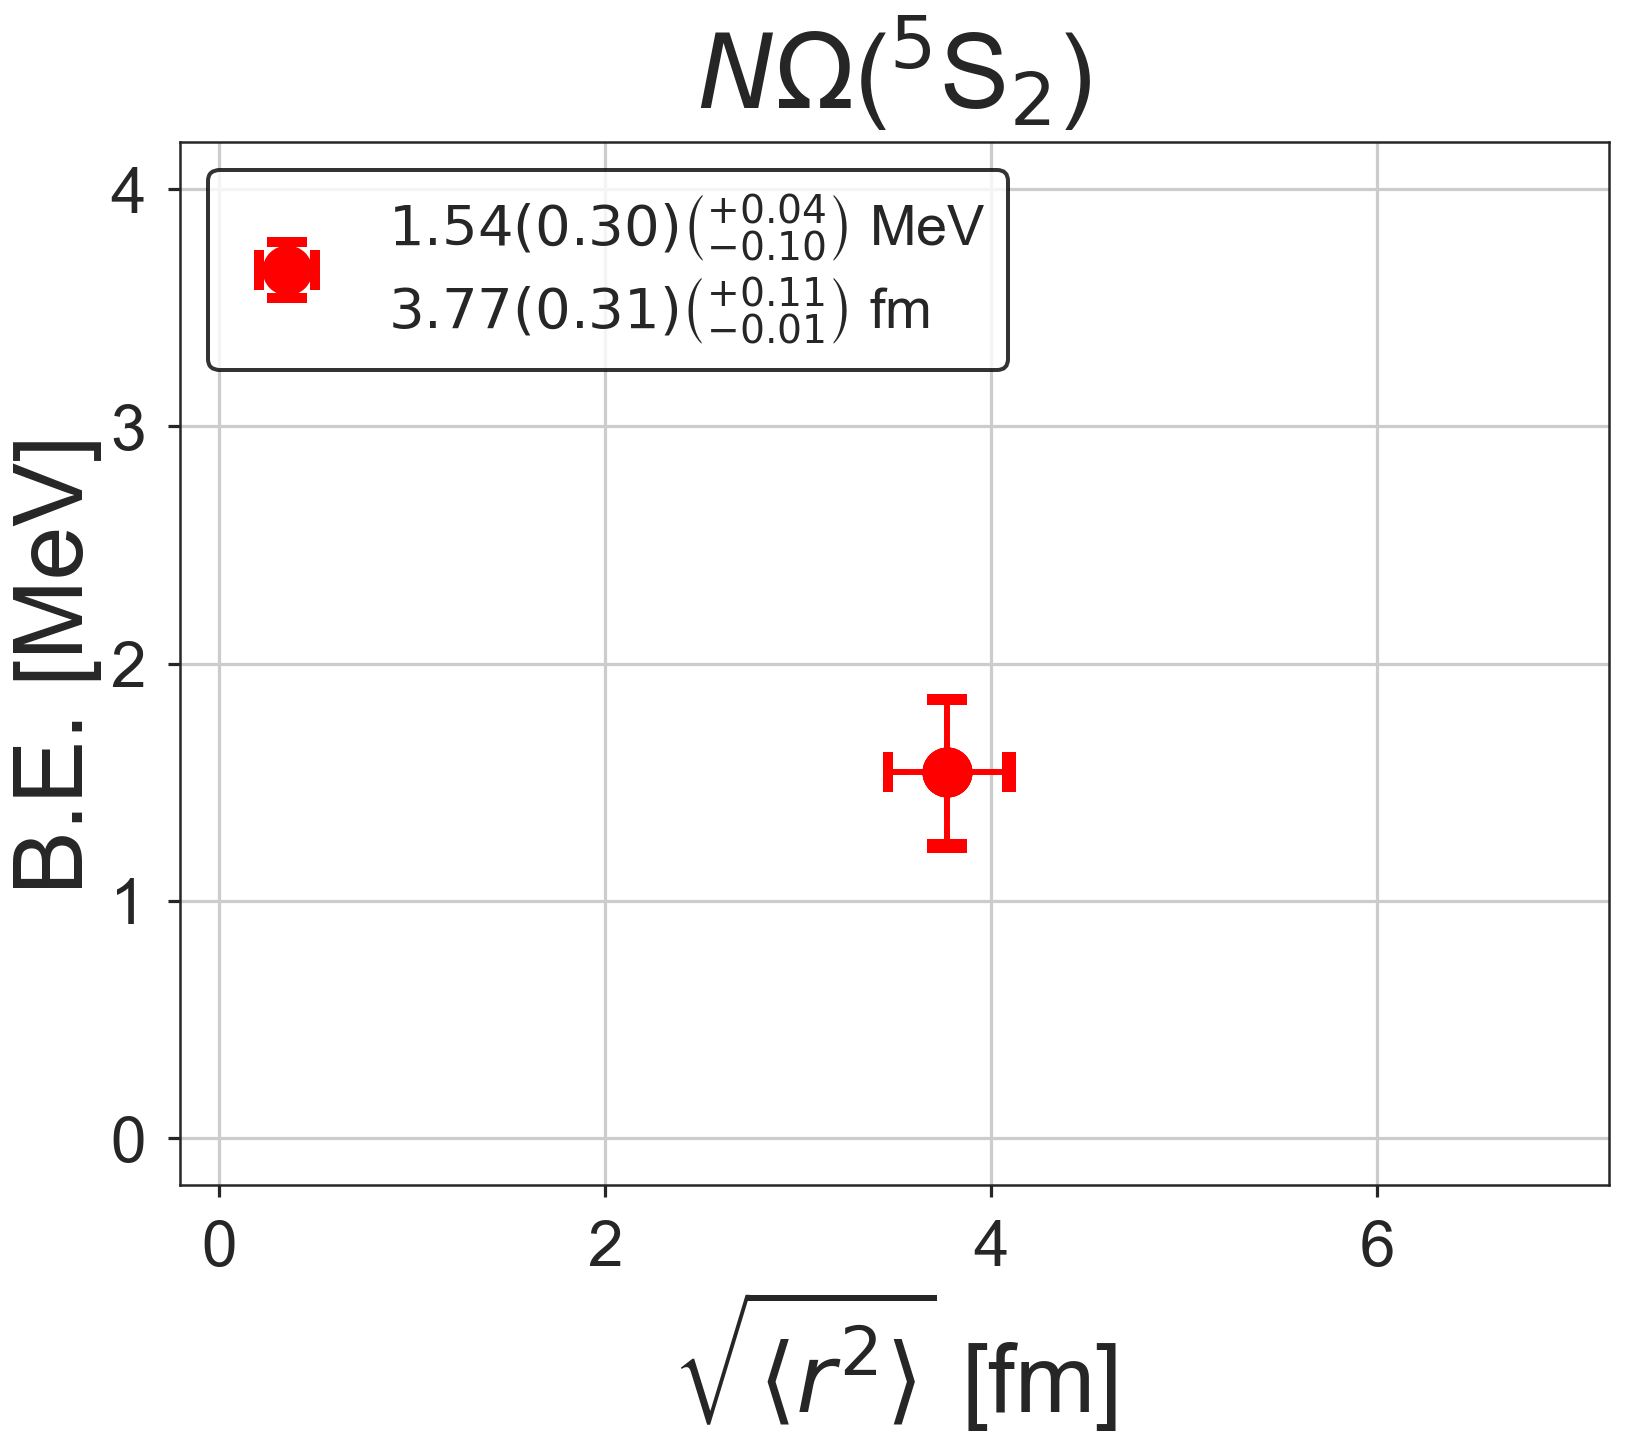

In [26]:
fig, ax = plt.subplots()

_xs =  RMS_jk[12]*lat_unit
_ys = - BE_jk[12]*ainv
xs_err = _xs.std()*np.sqrt(bin_num-1)
ys_err = _ys.std()*np.sqrt(bin_num-1)
xs_max = RMS_jk[13].mean()*lat_unit
xs_min = RMS_jk[14].mean()*lat_unit
ys_max = - BE_jk[14].mean()*ainv
ys_min = - BE_jk[13].mean()*ainv

ax.errorbar(_xs.mean(), _ys.mean(), ys_err, xerr=xs_err,
            fmt='o', ms=25, capthick=5, capsize=10, color='red')

xvals = _xs.mean(), xs_err, (xs_max-_xs.mean()), (xs_min - _xs.mean())
yvals = _ys.mean(), ys_err, (ys_max-_ys.mean()), (ys_min - _ys.mean())

print('{:3.2f}({:3.2f})({:+3.2f})({:+3.2f})'.format(_xs.mean(), xs_err, (xs_max-_xs.mean()), (xs_min - _xs.mean())))
print('{:3.2f}({:3.2f})({:+3.2f})({:+3.2f})'.format(_ys.mean(), ys_err, (ys_max-_ys.mean()), (ys_min - _ys.mean())))
tmp = xvals
xvals = yvals
yvals = tmp
result =r'${:3.2f}({:3.2f})\left(^{{{:+3.2f}}}_{{{:+3.2f}}}\right)$ MeV'.format(xvals[0], xvals[1], xvals[2], xvals[3]) \
  + '\n' + r'${:3.2f}({:3.2f})\left(^{{{:+3.2f}}}_{{{:+3.2f}}}\right)$ fm'.format(yvals[0], yvals[1], yvals[2], yvals[3])
ax.errorbar(_xs.mean(), _ys.mean(), ys_err, xerr=xs_err,
            fmt='o', ms=25, capthick=5, capsize=10, color='red',
           label=result)

eb = ax.errorbar(_xs.mean(), _ys.mean(),
           [[np.sqrt(ys_err**2 + (ys_min-_ys.mean())**2)],
           [np.sqrt(ys_err**2 + (ys_max-_ys.mean())**2)]],
           xerr = [[np.sqrt(xs_err**2 + (xs_min - _xs.mean())**2)],
                  [np.sqrt(xs_err**2 + (xs_max - _xs.mean())**2)]],
            fmt='o', ms=25, capthick=5, capsize=10, color='red')
eb[-1][0].set_linestyle('--')
eb[-1][1].set_linestyle('--')


ax.set_title(r'$N\Omega$($^5$S$_2$)', size=52, y=1.02)
ax.set_xlabel(r'$\sqrt{\langle r^2 \rangle}$ [fm]', size=48)
ax.set_ylabel(r'B.E. [MeV]', size=48)
ax.set_xlim(-0.2, 7.2)
ax.set_ylim(-0.2, 4.2)
ax.set_yticks([0,1,2,3,4])
leg = ax.legend(loc='upper left', frameon=True, fontsize=28)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
fig.savefig('../figs/binding_energy/rms_vs_be.pdf', bbox_inches='tight')

# with Coulomb interaction

In [27]:
V_fit_w_C = lambda p, x: V_fit(p, x) - (1.0/137.036)/x

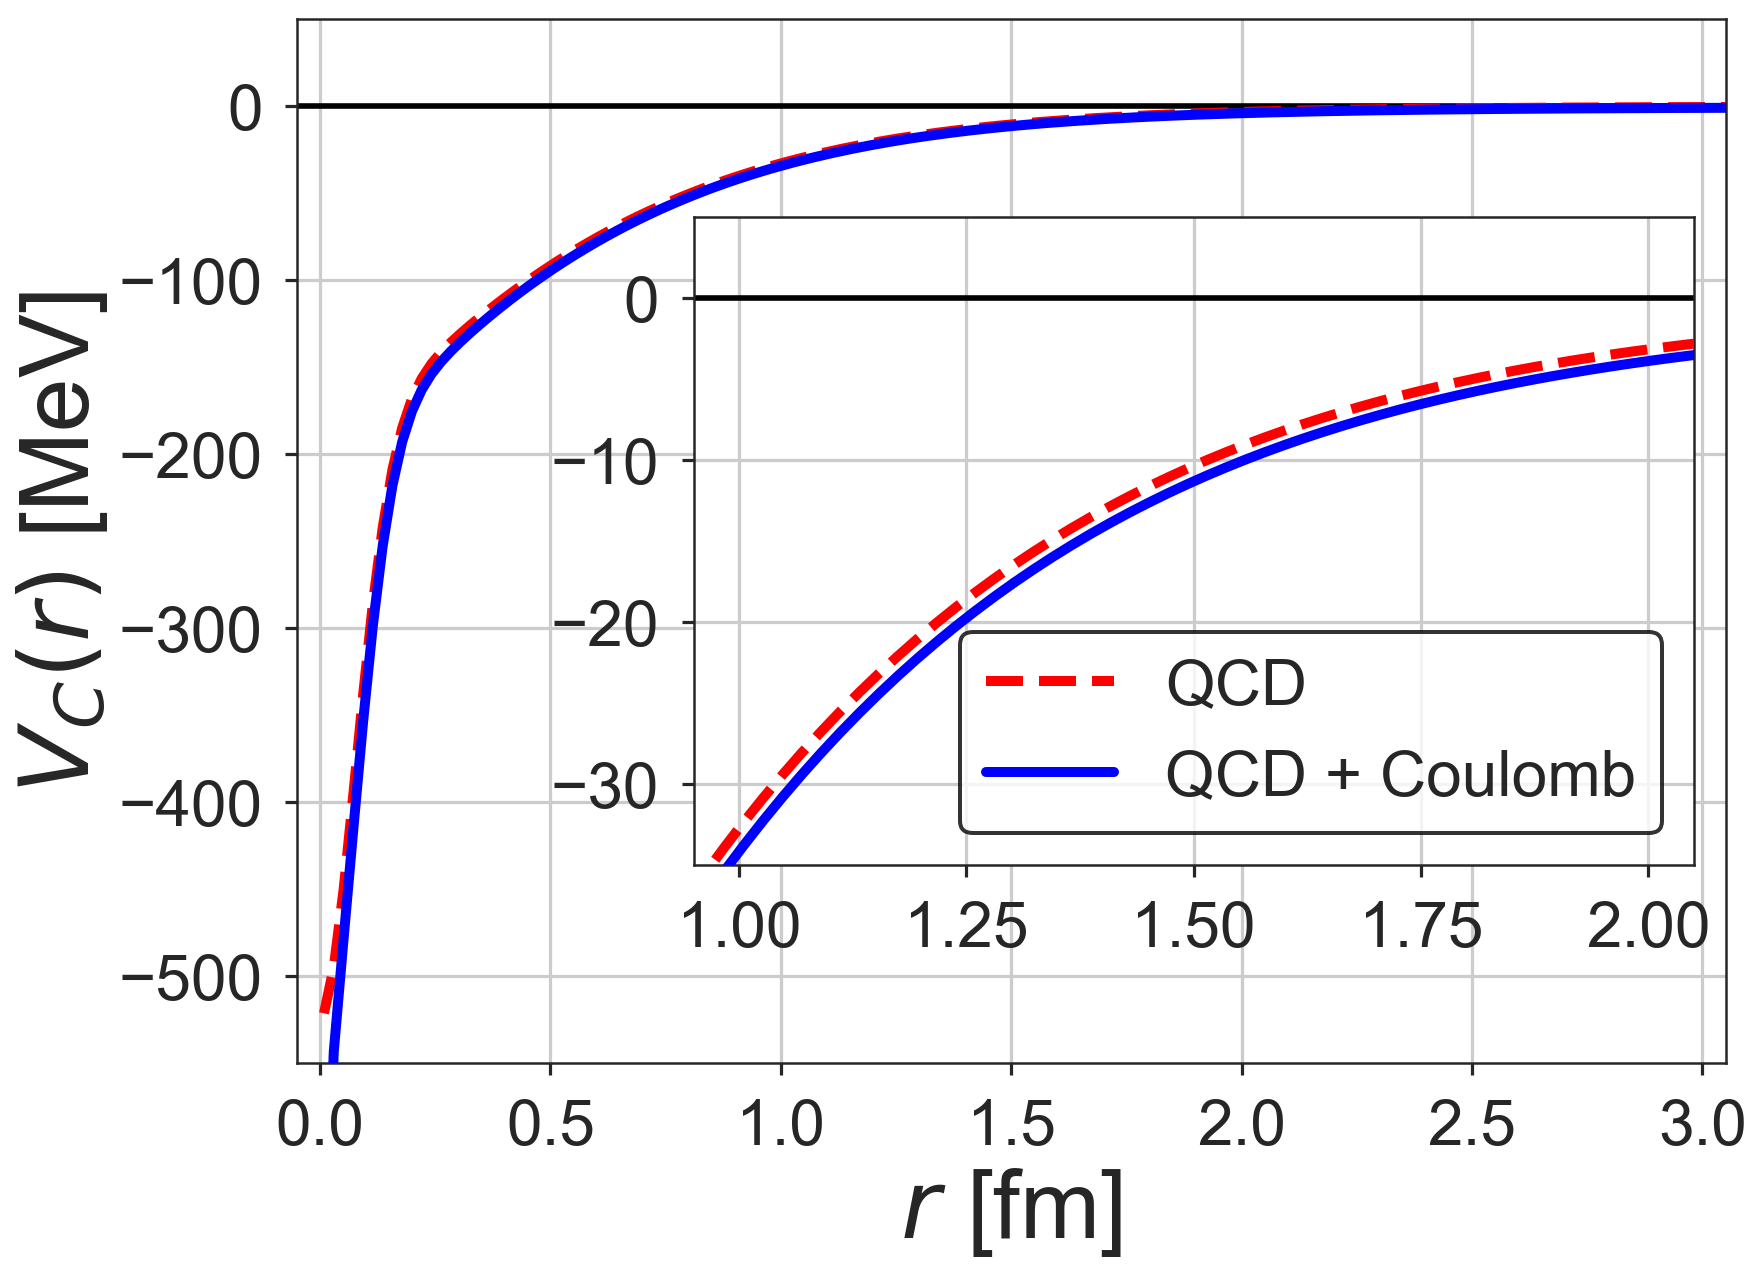

In [28]:
fig, ax = plt.subplots()
it = 12
xls = np.linspace(0.1, 50, 200)
ax.plot(xls*lat_unit, V_fit(FF_yukawa2_prm_av[it], xls)*ainv,
       color='red', linestyle='--', zorder=3, lw=5, label='QCD')
ax.plot(xls*lat_unit, V_fit_w_C(FF_yukawa2_prm_av[it], xls)*ainv,
       color='blue', linestyle='-', zorder=3, lw=5, label='QCD + Coulomb')

axins = inset_axes(ax, width='70%', height=4.5, loc=5)
axins.plot(xls*lat_unit, V_fit(FF_yukawa2_prm_av[it], xls)*ainv,
       color='red', linestyle='--', zorder=3, lw=5, label='QCD')
axins.plot(xls*lat_unit, V_fit_w_C(FF_yukawa2_prm_av[it], xls)*ainv,
       color='blue', zorder=3, linestyle='-', lw=5, label='QCD + Coulomb')
axins.set_xlim(0.95, 2.05)
axins.set_ylim(-35, 5)
axins.axhline(0, color='black')

ax.axhline(0, color='black')
ax.set_xlim(-0.05, 3.05)
ax.set_ylim(-550, 50)
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$V_C(r)$ [MeV]', size=48)
leg = axins.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
#fig.savefig('figs.v8/Vc_w_Coulomb_t12.pdf', bbox_inches='tight')

In [29]:
BE_w_C_jk = {}
RMS_w_C_jk = {}

In [30]:
it = 11
tmp_E = []
tmp_rms = []
print(f't = {it}')
for ibin in range(bin_num):
    pot = lambda x: V_fit_w_C(FF_yukawa2_prm_jk[it][ibin,:], x)
    sbs = Search_Bound_State(pot, m_red, r_max=30/lat_unit)
    E = sbs.calc_binding_energy(-3.8/ainv, -0.5/ainv)
    print(f'{ibin:02d} {E*ainv:3.2f} MeV', end=',')
    tmp_E.append(E)
    
    rms = sbs.calc_rms_distance(-3.8/ainv, -0.5/ainv)
    print(f' {rms*lat_unit:3.2f} fm')
    tmp_rms.append(rms)

BE_w_C_jk[it] = np.array(tmp_E)
RMS_w_C_jk[it] = np.array(tmp_rms)

t = 11
00 -2.52 MeV, 3.22 fm
01 -2.43 MeV, 3.27 fm
02 -2.41 MeV, 3.28 fm
03 -2.39 MeV, 3.29 fm
04 -2.31 MeV, 3.34 fm
05 -2.48 MeV, 3.24 fm
06 -2.25 MeV, 3.38 fm
07 -2.42 MeV, 3.28 fm
08 -2.40 MeV, 3.29 fm
09 -2.40 MeV, 3.29 fm
10 -2.50 MeV, 3.23 fm
11 -2.32 MeV, 3.33 fm
12 -2.31 MeV, 3.34 fm
13 -2.34 MeV, 3.32 fm
14 -2.36 MeV, 3.31 fm
15 -2.47 MeV, 3.25 fm
16 -2.55 MeV, 3.20 fm
17 -2.42 MeV, 3.27 fm
18 -2.39 MeV, 3.29 fm
19 -2.40 MeV, 3.29 fm


In [31]:
it = 12
tmp_E = []
tmp_rms = []
print(f't = {it}')
for ibin in range(bin_num):
    pot = lambda x: V_fit_w_C(FF_yukawa2_prm_jk[it][ibin,:], x)
    sbs = Search_Bound_State(pot, m_red, r_max=30/lat_unit)
    E = sbs.calc_binding_energy(-3.8/ainv, -0.5/ainv)
    print(f'{ibin:02d} {E*ainv:3.2f} MeV', end=',')
    tmp_E.append(E)
    
    rms = sbs.calc_rms_distance(-3.8/ainv, -0.5/ainv)
    print(f' {rms*lat_unit:3.2f} fm')
    tmp_rms.append(rms)

BE_w_C_jk[it] = np.array(tmp_E)
RMS_w_C_jk[it] = np.array(tmp_rms)

t = 12
00 -2.62 MeV, 3.16 fm
01 -2.47 MeV, 3.24 fm
02 -2.58 MeV, 3.18 fm
03 -2.50 MeV, 3.22 fm
04 -2.31 MeV, 3.33 fm
05 -2.44 MeV, 3.25 fm
06 -2.35 MeV, 3.31 fm
07 -2.52 MeV, 3.21 fm
08 -2.52 MeV, 3.21 fm
09 -2.48 MeV, 3.23 fm
10 -2.50 MeV, 3.22 fm
11 -2.52 MeV, 3.21 fm
12 -2.43 MeV, 3.26 fm
13 -2.35 MeV, 3.30 fm
14 -2.46 MeV, 3.24 fm
15 -2.51 MeV, 3.22 fm
16 -2.50 MeV, 3.22 fm
17 -2.39 MeV, 3.28 fm
18 -2.40 MeV, 3.28 fm
19 -2.37 MeV, 3.29 fm


In [32]:
it = 13
tmp_E = []
tmp_rms = []
print(f't = {it}')
for ibin in range(bin_num):
    pot = lambda x: V_fit_w_C(FF_yukawa2_prm_jk[it][ibin,:], x)
    sbs = Search_Bound_State(pot, m_red, r_max=30/lat_unit)
    E = sbs.calc_binding_energy(-3.8/ainv, -0.5/ainv)
    print(f'{ibin:02d} {E*ainv:3.2f} MeV', end=',')
    tmp_E.append(E)
    
    rms = sbs.calc_rms_distance(-3.8/ainv, -0.5/ainv)
    print(f' {rms*lat_unit:3.2f} fm')
    tmp_rms.append(rms)

BE_w_C_jk[it] = np.array(tmp_E)
RMS_w_C_jk[it] = np.array(tmp_rms)

t = 13
00 -2.44 MeV, 3.25 fm
01 -2.39 MeV, 3.28 fm
02 -2.63 MeV, 3.15 fm
03 -2.28 MeV, 3.35 fm
04 -2.21 MeV, 3.39 fm
05 -2.52 MeV, 3.21 fm
06 -2.45 MeV, 3.24 fm
07 -2.29 MeV, 3.34 fm
08 -2.41 MeV, 3.27 fm
09 -2.35 MeV, 3.30 fm
10 -2.18 MeV, 3.41 fm
11 -2.74 MeV, 3.09 fm
12 -2.26 MeV, 3.36 fm
13 -2.29 MeV, 3.34 fm
14 -2.39 MeV, 3.28 fm
15 -2.46 MeV, 3.24 fm
16 -2.29 MeV, 3.34 fm
17 -2.08 MeV, 3.48 fm
18 -2.19 MeV, 3.41 fm
19 -2.16 MeV, 3.42 fm


In [33]:
it = 14
tmp_E = []
tmp_rms = []
print(f't = {it}')
for ibin in range(bin_num):
    pot = lambda x: V_fit_w_C(FF_yukawa2_prm_jk[it][ibin,:], x)
    sbs = Search_Bound_State(pot, m_red, r_max=30/lat_unit)
    E = sbs.calc_binding_energy(-3.8/ainv, -0.5/ainv)
    print(f'{ibin:02d} {E*ainv:3.2f} MeV', end=',')
    tmp_E.append(E)
    
    rms = sbs.calc_rms_distance(-3.8/ainv, -0.5/ainv)
    print(f' {rms*lat_unit:3.2f} fm')
    tmp_rms.append(rms)

BE_w_C_jk[it] = np.array(tmp_E)
RMS_w_C_jk[it] = np.array(tmp_rms)

t = 14
00 -2.63 MeV, 3.17 fm
01 -2.37 MeV, 3.30 fm
02 -2.80 MeV, 3.08 fm
03 -2.23 MeV, 3.38 fm
04 -2.48 MeV, 3.24 fm
05 -2.76 MeV, 3.11 fm
06 -2.68 MeV, 3.14 fm
07 -2.21 MeV, 3.40 fm
08 -2.57 MeV, 3.20 fm
09 -2.53 MeV, 3.21 fm
10 -2.04 MeV, 3.52 fm
11 -3.25 MeV, 2.89 fm
12 -2.55 MeV, 3.21 fm
13 -2.35 MeV, 3.32 fm
14 -2.62 MeV, 3.18 fm
15 -2.65 MeV, 3.15 fm
16 -2.28 MeV, 3.36 fm
17 -2.15 MeV, 3.44 fm
18 -2.26 MeV, 3.37 fm
19 -2.54 MeV, 3.21 fm


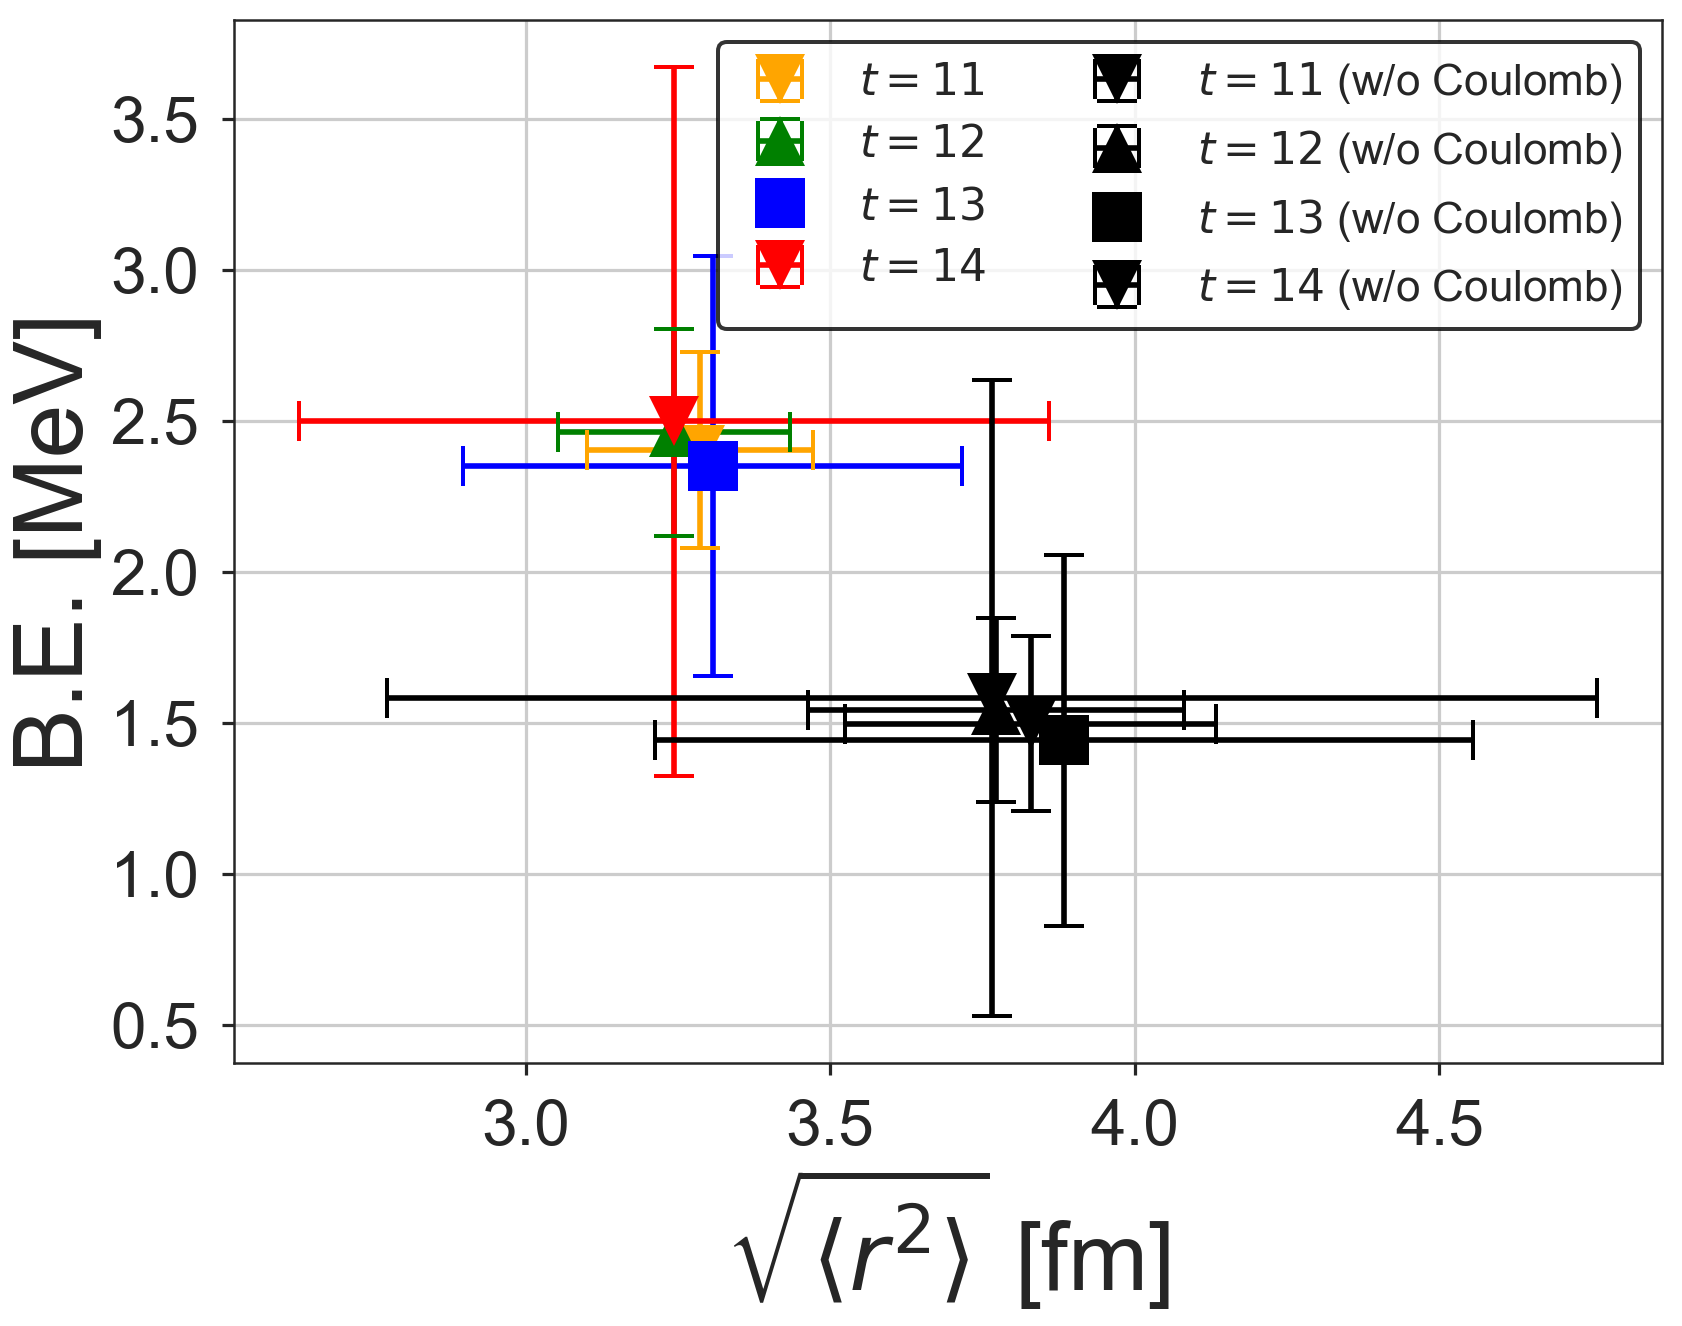

In [34]:
fig, ax = plt.subplots()
for it, fmt, col in zip([11, 12, 13, 14], ['v', '^', 's' ,'v'],
                        ['orange', 'green', 'blue', 'red']):
    _xs = RMS_w_C_jk[it]*lat_unit
    _ys = -BE_w_C_jk[it]*ainv
    ax.errorbar(_xs.mean(), _ys.mean(), _ys.std()*np.sqrt(bin_num-1),
               xerr = _xs.std()*np.sqrt(bin_num-1),
               fmt=fmt,color=col,ms=25, capsize=10, capthick=2.0,
               label=r'$t = {}$'.format(it))
    
for it, fmt, col in zip([11, 12, 13, 14], ['v', '^', 's', 'v'],
                        ['black', 'black', 'black', 'black']):
    _xs = RMS_jk[it]*lat_unit
    _ys = -BE_jk[it]*ainv
    ax.errorbar(_xs.mean(), _ys.mean(), _ys.std()*np.sqrt(bin_num-1),
               xerr = _xs.std()*np.sqrt(bin_num-1),
               fmt=fmt,color=col,ms=25, capsize=10, capthick=2.0,
               label=r'$t = {}$ (w/o Coulomb)'.format(it))
    
ax.set_xlabel(r'$\sqrt{\langle r^2 \rangle}$ [fm]', size=48)
ax.set_ylabel(r'B.E. [MeV]', size=48)
leg = ax.legend(ncol=2, frameon=True, fontsize=22)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
fig.savefig('../figs/binding_energy/RMS_BE_w_Coulomb_t11_14.pdf', bbox_inches='tight')

n Omega
3.77(0.31)(+0.11)(-0.01) fm
1.54(0.30)(+0.04)(-0.10) MeV
p Omega
3.24(0.19)(+0.06)(-0.00) fm
2.46(0.34)(+0.04)(-0.11) MeV


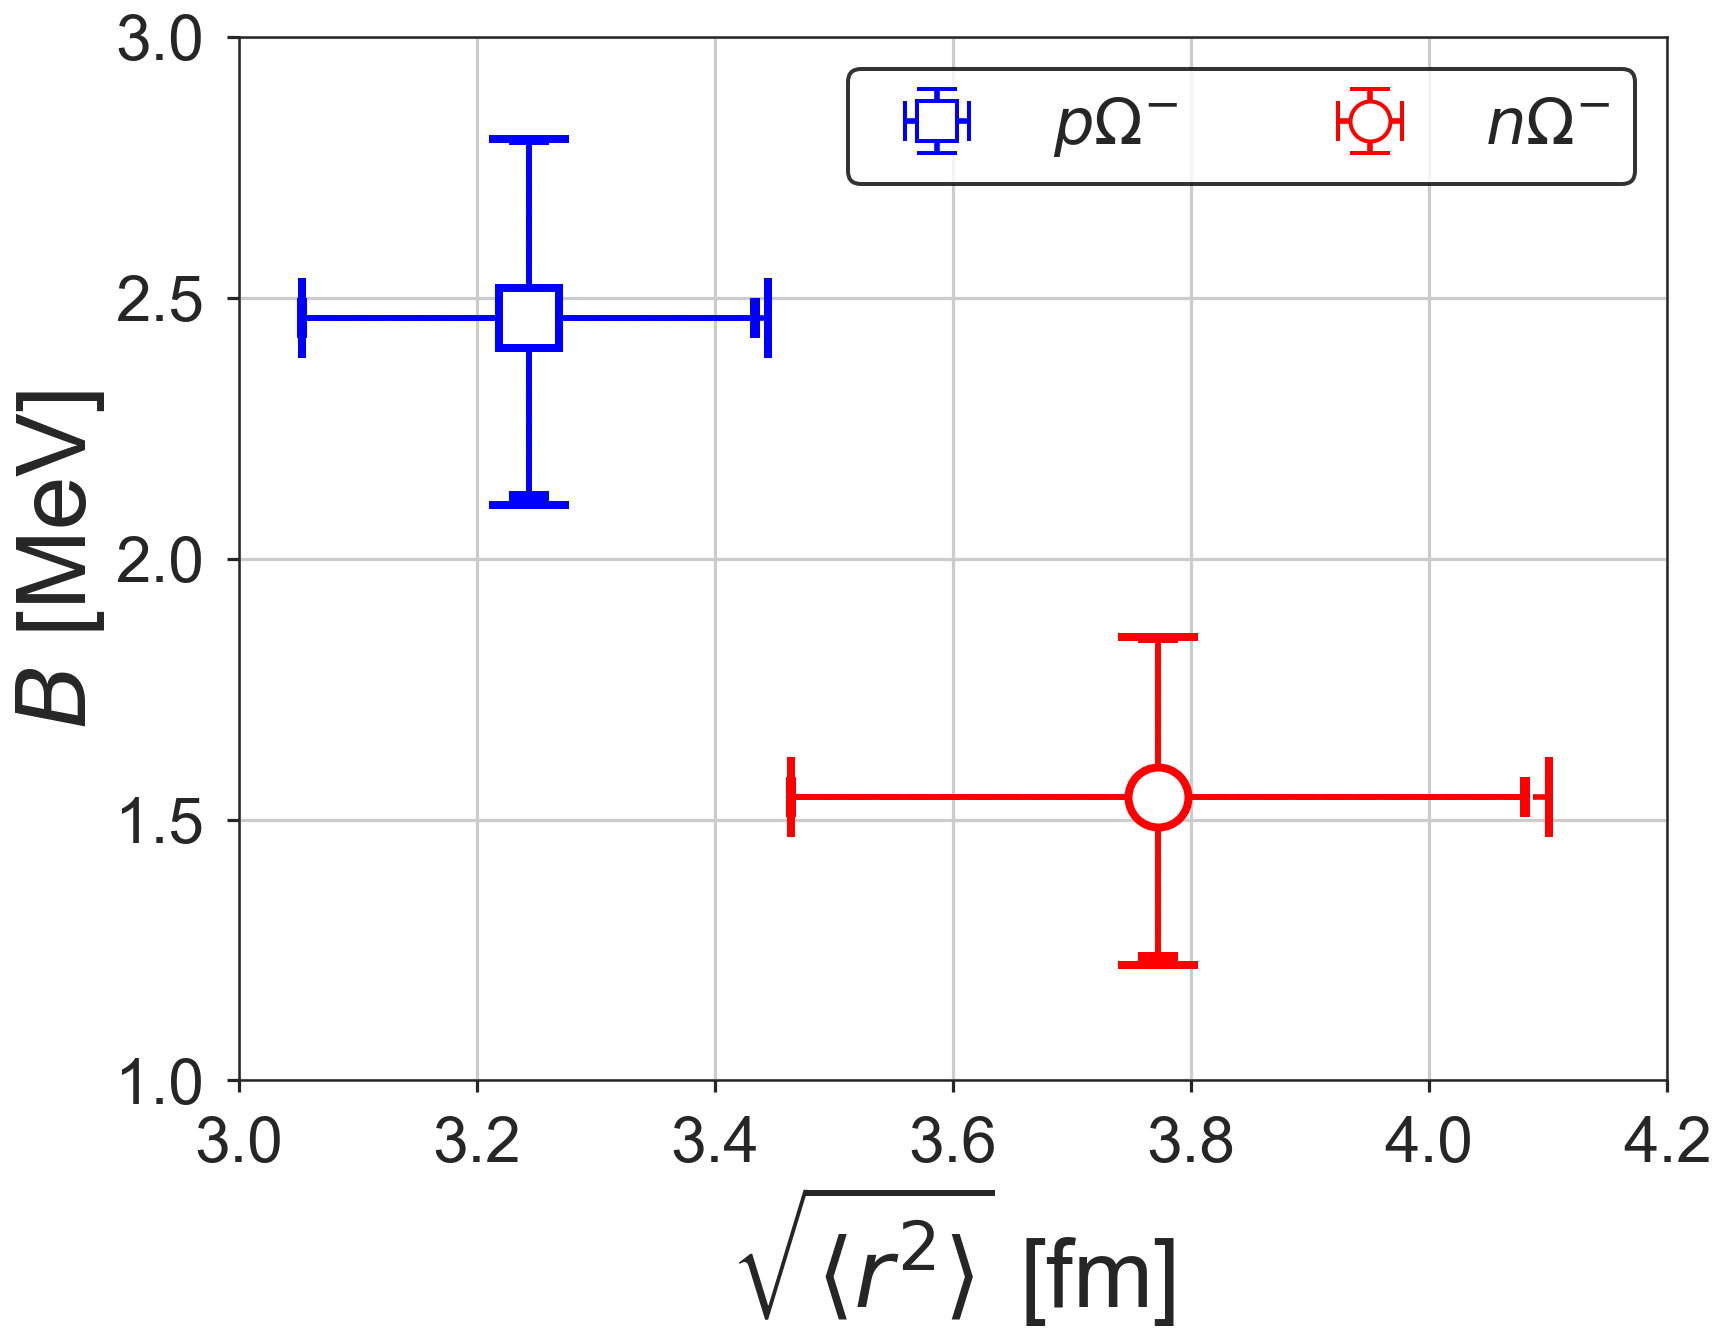

In [36]:
fig, ax = plt.subplots()

_xs =  RMS_jk[12]*lat_unit
_ys = - BE_jk[12]*ainv
xs_err = _xs.std()*np.sqrt(bin_num-1)
ys_err = _ys.std()*np.sqrt(bin_num-1)
xs_max = RMS_jk[13].mean()*lat_unit
xs_min = RMS_jk[14].mean()*lat_unit
ys_max = - BE_jk[14].mean()*ainv
ys_min = - BE_jk[13].mean()*ainv

ax.errorbar(_xs.mean(), _ys.mean(), ys_err, xerr=xs_err,
            fmt='o', ms=25, capthick=5, capsize=10, color='red')

xvals = _xs.mean(), xs_err, (xs_max-_xs.mean()), (xs_min - _xs.mean())
yvals = _ys.mean(), ys_err, (ys_max-_ys.mean()), (ys_min - _ys.mean())

print('n Omega')
print('{:3.2f}({:3.2f})({:+3.2f})({:+3.2f}) fm'.format(_xs.mean(), xs_err, (xs_max-_xs.mean()), (xs_min - _xs.mean())))
print('{:3.2f}({:3.2f})({:+3.2f})({:+3.2f}) MeV'.format(_ys.mean(), ys_err, (ys_max-_ys.mean()), (ys_min - _ys.mean())))
result = r'${:3.2f}({:3.2f})\left(^{{{:+3.2f}}}_{{{:+3.2f}}}\right)$ MeV'.format(yvals[0], yvals[1], yvals[2], yvals[3]) \
    + '\n' + r'${:3.2f}({:3.2f})\left(^{{{:+3.2f}}}_{{{:+3.2f}}}\right)$ fm'.format(xvals[0], xvals[1], xvals[2], xvals[3]) 
    
ax.errorbar(_xs.mean(), _ys.mean(), ys_err, xerr=xs_err,
            fmt='o', ms=20, capthick=1, capsize=10, color='red', mfc='white', mew=2.0,
           label=r'$n\Omega^{-}$')

eb = ax.errorbar(_xs.mean(), _ys.mean(),
           [[np.sqrt(ys_err**2 + (ys_min-_ys.mean())**2)],
           [np.sqrt(ys_err**2 + (ys_max-_ys.mean())**2)]],
           xerr = [[np.sqrt(xs_err**2 + (xs_min - _xs.mean())**2)],
                  [np.sqrt(xs_err**2 + (xs_max - _xs.mean())**2)]],
            fmt='o', ms=30, capthick=1, capsize=20, color='red', mfc='white', mew=4.0)
eb[-1][0].set_linestyle('--')
eb[-1][1].set_linestyle('--')


# w/ Coulomb
_xs =  RMS_w_C_jk[12]*lat_unit
_ys = - BE_w_C_jk[12]*ainv
xs_err = _xs.std()*np.sqrt(bin_num-1)
ys_err = _ys.std()*np.sqrt(bin_num-1)
xs_max = RMS_w_C_jk[13].mean()*lat_unit
xs_min = RMS_w_C_jk[14].mean()*lat_unit
ys_max = - BE_w_C_jk[14].mean()*ainv
ys_min = - BE_w_C_jk[13].mean()*ainv

ax.errorbar(_xs.mean(), _ys.mean(), ys_err, xerr=xs_err,
            fmt='s', ms=25, capthick=5, capsize=10, color='blue')

xvals = _xs.mean(), xs_err, (xs_max-_xs.mean()), (xs_min - _xs.mean())
yvals = _ys.mean(), ys_err, (ys_max-_ys.mean()), (ys_min - _ys.mean())

print('p Omega')
print('{:3.2f}({:3.2f})({:+3.2f})({:+3.2f}) fm'.format(_xs.mean(), xs_err, (xs_max-_xs.mean()), (xs_min - _xs.mean())))
print('{:3.2f}({:3.2f})({:+3.2f})({:+3.2f}) MeV'.format(_ys.mean(), ys_err, (ys_max-_ys.mean()), (ys_min - _ys.mean())))
result = r'${:3.2f}({:3.2f})\left(^{{{:+3.2f}}}_{{{:+3.2f}}}\right)$ MeV'.format(yvals[0], yvals[1], yvals[2], yvals[3]) \
        + '\n' + r'${:3.2f}({:3.2f})\left(^{{{:+3.2f}}}_{{{:+3.2f}}}\right)$ fm'.format(xvals[0], xvals[1], xvals[2], xvals[3])
    
    
ax.errorbar(_xs.mean(), _ys.mean(), ys_err, xerr=xs_err,
            fmt='s', ms=20, capthick=1, capsize=10, color='blue', mfc='white', mew=2.0,
           label=r'$p\Omega^{-}$')

eb2 = ax.errorbar(_xs.mean(), _ys.mean(),
           [[np.sqrt(ys_err**2 + (ys_min-_ys.mean())**2)],
           [np.sqrt(ys_err**2 + (ys_max-_ys.mean())**2)]],
           xerr = [[np.sqrt(xs_err**2 + (xs_min - _xs.mean())**2)],
                  [np.sqrt(xs_err**2 + (xs_max - _xs.mean())**2)]],
            fmt='s', ms=30, capthick=1, capsize=20, color='blue', mfc='white', mew=4.0)
eb2[-1][0].set_linestyle('--')
eb2[-1][1].set_linestyle('--')

#ax.set_title(r'$N\Omega$($^5$S$_2$)', size=52, y=1.02)
ax.set_xlabel(r'$\sqrt{\langle r^2 \rangle}$ [fm]', size=48)
ax.set_ylabel(r'$B$ [MeV]', size=48)
ax.set_xlim(3.0, 4.2)
ax.set_ylim(1.0, 3.0)
#ax.set_xlim(3,4)
#ax.set_ylim(1,3)
ax.set_yticks([1, 1.5, 2.0, 2.5, 3.0])
props = dict(boxstyle='round', facecolor='white', alpha=0.8, linewidth=2.0)
#ax.text(0.6, 2.9, 'QCD + Coulomb', color='blue', bbox=props)
#ax.text(5.2, 0.5, 'QCD', color='red', bbox=props)
ll, hh = ax.get_legend_handles_labels()
ll = [ll[1], ll[0]]
hh = [hh[1], hh[0]]
leg = ax.legend(ll, hh, ncol=2, loc='upper right', frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
fig.savefig('../figs/binding_energy/RMS_BE_nOmega_pOmega.pdf', bbox_inches='tight')